In [1]:
import os
import random
import itertools
import re

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_analyzer import CustomPairPlot
import graphviz
import pydotplus
from IPython.display import Image
from IPython.display import HTML
from six import StringIO
from ipywidgets import interact, FloatSlider

# データセット分割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

# 補完
from sklearn.experimental import (
    enable_iterative_imputer,
)  # IterativeImputerをimportするために必要
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# エンコード
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

# サンプリング
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# 特徴量選択
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import (
    GenericUnivariateSelect,
    f_classif,
    mutual_info_classif,
    chi2,
)
from boruta import BorutaPy
from libraries.mrmr import mrmr

# 学習中
import optuna
from tqdm import tqdm
from sklearn.model_selection import learning_curve, cross_validate, cross_val_score

# 評価指標
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings


# config python file
import config

SEED = config.SEED


from functions import *

fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

# 目的
遺伝子学的分類に基づいた、予後の2値分類を実施する。  
分類はCLAUDIN_SUBTYPEに基づいて実施。  
予後は5年、10年、15年の3つの年次に分けている。Trueで死亡であることに注意すること。

# データ読み込み
読み込み元：
    config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/claudin_subtype_chi2"

サブタイプ毎のデータを使用 

In [2]:
X_dict = pickle_load(
    config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/X_dict.pickle"
)
y_dict = pickle_load(
    config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/y_dict.pickle"
)

# モデルのトレーニング

## ベースモデルの学習結果

各特徴量選択されたdfを用いて基本的な2値分類モデルを学習する

### chi2

#### chi2 (basic)

In [3]:
for year in range(5, 16, 5):  # 予後年数毎のループ
    prognosis_Xlabel = "X{0:0=2}".format(year)
    prognosis_ylabel = "y{0:0=2}".format(year)

    # compare_bcmsは内部でk分割交差検証を行うので、train_test_splitをしなくて良い
    X_train = X_dict["basic"]["chi2"]["train"][prognosis_Xlabel]
    y_train = y_dict["basic"]["chi2"]["train"][prognosis_ylabel]

    # accuracyの表示
    print("----------" * 10)
    print("予後年数：{0:0=2}年:".format(year))
    if accuracy_score(y_train, np.zeros(len(y_train))) >= 0.5:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.zeros(len(y_train))), 3),
        )
    else:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.ones(len(y_train))), 3),
        )
    print("accuracyベースライン：", score)
    print("使用特徴量：", X_train.columns)
    print("学習サンプルサイズ：", X_train.shape)
    display("ラベル比率：", y_train.value_counts())

    save_dir = (
        config.TABLES_MODELS_PROGNOSIS_CROSS_DIR + "/scores_base-model/basic/chi2"
    )
    make_dir(save_dir)
    display(
        compare_bcms(X_train, y_train, save_path=save_dir + "/{0:0=2}.csv".format(year))
    )

----------------------------------------------------------------------------------------------------
予後年数：05年:
accuracyベースライン： ('0>1', 0.814)
使用特徴量： Index(['KIF5C', 'GJA1', 'SERPINA1', 'AIF1L', 'TTYH1', 'CCDC74A', 'CBX2',
       'CAPN8', 'LYPD6B', 'KRT7',
       ...
       'PREX1', 'AFF3', 'BUB1', 'GAL', 'PMP22', 'UBE2S', 'CKAP2L', 'INPP5J',
       'RGS22', 'SLC39A6'],
      dtype='object', length=303)
学習サンプルサイズ： (1293, 303)


'ラベル比率：'

0    1053
1     240
Name: OS_05years, dtype: int64

11it [00:57,  5.23s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.718570,0.716893,0.462321,0.457962
Polynomial SVM,0.992180,0.777275,0.978554,0.395727
Logistic Regression,0.919310,0.775707,0.759078,0.376035
AdaBoost,0.910027,0.797346,0.725492,0.365001
Linear SVM,0.943284,0.753298,0.836039,0.342695
Decision Tree,0.885796,0.778825,0.655793,0.334453
Nearest Neighbors,0.849876,0.791169,0.517605,0.332916
RBF SVM,0.831657,0.818247,0.189959,0.110062
Random Forest,0.865514,0.816702,0.431688,0.047077


----------------------------------------------------------------------------------------------------
予後年数：10年:
accuracyベースライン： ('0>1', 0.644)
使用特徴量： Index(['KIF5C', 'LTF', 'SERPINA1', 'FCER1A', 'CCDC74A', 'CBX2', 'CAPN8',
       'CA12', 'NDP', 'SLC27A2',
       ...
       'ANKRD30BP3', 'KIF1A', 'RTN1', 'MYBPC1', 'PRC1', 'ELOVL5', 'GLYATL2',
       'AFF3', 'UBE2S', 'SLC39A6'],
      dtype='object', length=144)
学習サンプルサイズ： (1036, 144)


'ラベル比率：'

0    667
1    369
Name: OS_10years, dtype: int64

11it [00:33,  3.06s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.666989,0.662239,0.571416,0.564048
Polynomial SVM,0.916668,0.713424,0.875498,0.563386
AdaBoost,0.841376,0.691141,0.764514,0.539446
Linear SVM,0.809309,0.696919,0.712923,0.538503
Logistic Regression,0.795367,0.696975,0.688725,0.533830
Nearest Neighbors,0.793009,0.699944,0.687728,0.524714
RBF SVM,0.770271,0.726848,0.595559,0.513184
Random Forest,0.860254,0.725934,0.770635,0.509953
Decision Tree,0.828188,0.658392,0.746828,0.491951


----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.537)
使用特徴量： Index(['S100A9', 'LOC389033', 'TAT', 'CDCA5', 'CCDC74A', 'HER2_STATUS', 'TCN1',
       'ANKRD30A', 'FGD3', 'CYP4F22', 'CALML5', 'NDP', 'NPI', 'BEX1', 'CDC20',
       'SLC7A2', 'BCL2', 'VTCN1', 'CLIC6', 'UBE2C',
       'LYMPH_NODES_EXAMINED_POSITIVE', 'ESR1', 'C1orf106', 'TMEM26', 'GSTM2',
       'S100P', 'MAPT', 'STC2', 'SCUBE2', 'CLEC3A', 'MYBPC1', 'PR_STATUS',
       'S100A8', 'TUBA3D', 'NAT1', 'GLYATL2', 'GRB7', 'AFF3', 'SUSD3', 'PDZK1',
       'TUMOR_SIZE'],
      dtype='object')
学習サンプルサイズ： (792, 41)


'ラベル比率：'

1    425
0    367
Name: OS_15years, dtype: int64

11it [00:09,  1.21it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Random Forest,0.824776,0.665364,0.844280,0.706598
RBF SVM,0.706929,0.674130,0.736520,0.704805
Polynomial SVM,0.764168,0.680411,0.780281,0.698460
Sigmoid SVM,0.536616,0.536614,0.698439,0.698420
Logistic Regression,0.713803,0.666519,0.735071,0.687257
Linear SVM,0.718152,0.661440,0.739335,0.681960
Nearest Neighbors,0.773146,0.648972,0.788825,0.672943
Quadratic Discriminant Analysis,0.813832,0.652832,0.822851,0.667543
Naive Bayes,0.658952,0.654066,0.667309,0.661710


#### chi2 (immunity)

In [4]:
for year in range(5, 16, 5):  # 予後年数毎のループ
    prognosis_Xlabel = "X{0:0=2}".format(year)
    prognosis_ylabel = "y{0:0=2}".format(year)

    # compare_bcmsは内部でk分割交差検証を行うので、train_test_splitをしなくて良い
    X_train = X_dict["immunity"]["chi2"]["train"][prognosis_Xlabel]
    y_train = y_dict["immunity"]["chi2"]["train"][prognosis_ylabel]

    # accuracyの表示
    print("----------" * 10)
    print("予後年数：{0:0=2}年:".format(year))
    if accuracy_score(y_train, np.zeros(len(y_train))) >= 0.5:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.zeros(len(y_train))), 3),
        )
    else:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.ones(len(y_train))), 3),
        )
    print("accuracyベースライン：", score)
    print("使用特徴量：", X_train.columns)
    print("学習サンプルサイズ：", X_train.shape)
    display("ラベル比率：", y_train.value_counts())
    save_dir = (
        config.TABLES_MODELS_PROGNOSIS_CROSS_DIR + "/scores_base-model/immunity/chi2"
    )
    make_dir(save_dir)
    display(
        compare_bcms(X_train, y_train, save_path=save_dir + "/{0:0=2}.csv".format(year))
    )

----------------------------------------------------------------------------------------------------
予後年数：05年:
accuracyベースライン： ('0>1', 0.814)
使用特徴量： Index(['KIF5C', 'GJA1', 'SERPINA1', 'AIF1L', 'TTYH1', 'CCDC74A', 'CBX2',
       'CAPN8', 'LYPD6B', 'KRT7',
       ...
       'PREX1', 'AFF3', 'BUB1', 'GAL', 'PMP22', 'UBE2S', 'CKAP2L', 'INPP5J',
       'RGS22', 'SLC39A6'],
      dtype='object', length=300)
学習サンプルサイズ： (1293, 300)


'ラベル比率：'

0    1053
1     240
Name: OS_05years, dtype: int64

11it [00:47,  4.30s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.718570,0.714586,0.462502,0.456036
Nearest Neighbors,0.843259,0.788122,0.473606,0.331646
Polynomial SVM,0.999914,0.739362,0.999768,0.313391
Logistic Regression,0.904013,0.750978,0.703768,0.303217
Linear SVM,0.927473,0.722361,0.785972,0.281763
AdaBoost,0.899286,0.772606,0.678422,0.247019
Decision Tree,0.878062,0.767949,0.621368,0.232547
Random Forest,0.855546,0.813608,0.362061,0.008000
Quadratic Discriminant Analysis,0.984876,0.814383,0.957520,0.000000


----------------------------------------------------------------------------------------------------
予後年数：10年:
accuracyベースライン： ('0>1', 0.644)
使用特徴量： Index(['KIF5C', 'LTF', 'SERPINA1', 'FCER1A', 'CCDC74A', 'CBX2', 'CAPN8',
       'CA12', 'NDP', 'SLC27A2',
       ...
       'ANKRD30BP3', 'KIF1A', 'RTN1', 'MYBPC1', 'PRC1', 'ELOVL5', 'GLYATL2',
       'AFF3', 'UBE2S', 'SLC39A6'],
      dtype='object', length=141)
学習サンプルサイズ： (1036, 141)


'ラベル比率：'

0    667
1    369
Name: OS_10years, dtype: int64

11it [00:28,  2.63s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.656050,0.653575,0.556624,0.551420
Polynomial SVM,0.993136,0.633168,0.990301,0.473671
Logistic Regression,0.759115,0.643885,0.628935,0.453432
Nearest Neighbors,0.755364,0.638107,0.625787,0.444688
Decision Tree,0.814028,0.613900,0.726550,0.444361
Linear SVM,0.766625,0.632291,0.645145,0.437645
Random Forest,0.864221,0.680527,0.772000,0.426559
RBF SVM,0.747319,0.685409,0.533000,0.417230
AdaBoost,0.827222,0.605246,0.742824,0.401455


----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.537)
使用特徴量： Index(['S100A9', 'LOC389033', 'TAT', 'CDCA5', 'CCDC74A', 'HER2_STATUS', 'TCN1',
       'ANKRD30A', 'FGD3', 'CYP4F22', 'CALML5', 'NDP', 'BEX1', 'CDC20',
       'SLC7A2', 'BCL2', 'VTCN1', 'CLIC6', 'UBE2C', 'ESR1', 'C1orf106',
       'TMEM26', 'GSTM2', 'S100P', 'MAPT', 'STC2', 'SCUBE2', 'CLEC3A',
       'MYBPC1', 'PR_STATUS', 'S100A8', 'TUBA3D', 'NAT1', 'GLYATL2', 'GRB7',
       'AFF3', 'SUSD3', 'PDZK1'],
      dtype='object')
学習サンプルサイズ： (792, 38)


'ラベル比率：'

1    425
0    367
Name: OS_15years, dtype: int64

11it [00:08,  1.25it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
RBF SVM,0.716190,0.652785,0.760828,0.705363
Random Forest,0.801906,0.656646,0.827336,0.703820
Sigmoid SVM,0.536616,0.536614,0.698439,0.698420
Linear SVM,0.689954,0.645142,0.726141,0.686629
Logistic Regression,0.683922,0.631218,0.717972,0.668712
Nearest Neighbors,0.744528,0.607326,0.771178,0.657005
Polynomial SVM,0.852132,0.597215,0.866449,0.646525
Quadratic Discriminant Analysis,0.788860,0.603608,0.809763,0.632588
Naive Bayes,0.628790,0.621329,0.637821,0.629297


#### chi2 (genes)

In [5]:
for year in range(5, 16, 5):  # 予後年数毎のループ
    prognosis_Xlabel = "X{0:0=2}".format(year)
    prognosis_ylabel = "y{0:0=2}".format(year)

    # compare_bcmsは内部でk分割交差検証を行うので、train_test_splitをしなくて良い
    X_train = X_dict["genes"]["chi2"]["train"][prognosis_Xlabel]
    y_train = y_dict["genes"]["chi2"]["train"][prognosis_ylabel]

    # accuracyの表示
    print("----------" * 10)
    print("予後年数：{0:0=2}年:".format(year))
    if accuracy_score(y_train, np.zeros(len(y_train))) >= 0.5:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.zeros(len(y_train))), 3),
        )
    else:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.ones(len(y_train))), 3),
        )
    print("accuracyベースライン：", score)
    print("使用特徴量：", X_train.columns)
    print("学習サンプルサイズ：", X_train.shape)
    display("ラベル比率：", y_train.value_counts())
    save_dir = (
        config.TABLES_MODELS_PROGNOSIS_CROSS_DIR + "/scores_base-model/genes/chi2"
    )
    make_dir(save_dir)
    display(
        compare_bcms(X_train, y_train, save_path=save_dir + "/{0:0=2}.csv".format(year))
    )

----------------------------------------------------------------------------------------------------
予後年数：05年:
accuracyベースライン： ('0>1', 0.814)
使用特徴量： Index(['KIF5C', 'SERPINA1', 'AIF1L', 'TTYH1', 'CCDC74A', 'CBX2', 'CAPN8',
       'LYPD6B', 'KRT7', 'CA12',
       ...
       'PREX1', 'AFF3', 'BUB1', 'GAL', 'PMP22', 'UBE2S', 'CKAP2L', 'INPP5J',
       'RGS22', 'SLC39A6'],
      dtype='object', length=297)
学習サンプルサイズ： (1293, 297)


'ラベル比率：'

0    1053
1     240
Name: OS_05years, dtype: int64

11it [00:50,  4.56s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.718312,0.716136,0.462809,0.457324
Nearest Neighbors,0.843001,0.790447,0.474140,0.333732
Polynomial SVM,1.000000,0.736261,1.000000,0.321431
Logistic Regression,0.903498,0.754830,0.702918,0.308439
Linear SVM,0.926270,0.724663,0.782374,0.285187
AdaBoost,0.899286,0.772606,0.678422,0.247019
Decision Tree,0.878062,0.769487,0.622091,0.240918
Quadratic Discriminant Analysis,0.985563,0.814383,0.959532,0.000000
RBF SVM,0.815245,0.814383,0.009166,0.000000


----------------------------------------------------------------------------------------------------
予後年数：10年:
accuracyベースライン： ('0>1', 0.644)
使用特徴量： Index(['KIF5C', 'LTF', 'SERPINA1', 'FCER1A', 'CCDC74A', 'CBX2', 'CAPN8',
       'CA12', 'NDP', 'SLC27A2',
       ...
       'ANKRD30BP3', 'KIF1A', 'RTN1', 'MYBPC1', 'PRC1', 'ELOVL5', 'GLYATL2',
       'AFF3', 'UBE2S', 'SLC39A6'],
      dtype='object', length=138)
学習サンプルサイズ： (1036, 138)


'ラベル比率：'

0    667
1    369
Name: OS_10years, dtype: int64

11it [00:27,  2.51s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.656801,0.655499,0.558258,0.554661
Polynomial SVM,1.000000,0.620640,1.000000,0.465166
Linear SVM,0.766197,0.640945,0.645150,0.455691
Nearest Neighbors,0.755686,0.640021,0.626484,0.447589
RBF SVM,0.774561,0.692158,0.599061,0.443694
Decision Tree,0.813599,0.613900,0.725450,0.439941
Logistic Regression,0.756542,0.640030,0.624873,0.438683
Random Forest,0.865402,0.676680,0.774868,0.419906
AdaBoost,0.827222,0.605246,0.742824,0.401455


----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.537)
使用特徴量： Index(['S100A9', 'LOC389033', 'TAT', 'CDCA5', 'CCDC74A', 'TCN1', 'ANKRD30A',
       'FGD3', 'CYP4F22', 'CALML5', 'NDP', 'BEX1', 'CDC20', 'SLC7A2', 'BCL2',
       'VTCN1', 'CLIC6', 'UBE2C', 'ESR1', 'C1orf106', 'TMEM26', 'GSTM2',
       'S100P', 'MAPT', 'STC2', 'SCUBE2', 'CLEC3A', 'MYBPC1', 'S100A8',
       'TUBA3D', 'NAT1', 'GLYATL2', 'GRB7', 'AFF3', 'SUSD3', 'PDZK1'],
      dtype='object')
学習サンプルサイズ： (792, 36)


'ラベル比率：'

1    425
0    367
Name: OS_15years, dtype: int64

11it [00:10,  1.03it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
RBF SVM,0.746774,0.656598,0.785460,0.706686
Sigmoid SVM,0.536616,0.536614,0.698439,0.698420
Random Forest,0.801624,0.645285,0.826726,0.695988
Linear SVM,0.691919,0.648940,0.729424,0.690873
Logistic Regression,0.682799,0.635047,0.717412,0.673070
Nearest Neighbors,0.747755,0.611108,0.773864,0.660027
Quadratic Discriminant Analysis,0.785214,0.611187,0.808327,0.644689
Naive Bayes,0.636364,0.627674,0.650262,0.639872
AdaBoost,0.797136,0.590965,0.815595,0.626512


### boruta

#### boruta (basic)

In [6]:
for year in range(5, 16, 5):  # 予後年数毎のループ
    prognosis_Xlabel = "X{0:0=2}".format(year)
    prognosis_ylabel = "y{0:0=2}".format(year)

    X_train = X_dict["basic"]["boruta"]["train"][prognosis_Xlabel]
    y_train = y_dict["basic"]["boruta"]["train"][prognosis_ylabel]

    assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"

    # accuracyの表示
    print("----------" * 10)
    print("予後年数：{0:0=2}年:".format(year))
    if accuracy_score(y_train, np.zeros(len(y_train))) >= 0.5:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.zeros(len(y_train))), 3),
        )
    else:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.ones(len(y_train))), 3),
        )
    print("accuracyベースライン：", score)
    print("使用特徴量：", X_train.columns)
    print("学習サンプルサイズ：", X_train.shape)
    display("ラベル比率：", y_train.value_counts())
    save_dir = (
        config.TABLES_MODELS_PROGNOSIS_CROSS_DIR + "/scores_base-model/basic/boruta"
    )
    make_dir(save_dir)
    display(
        compare_bcms(X_train, y_train, save_path=save_dir + "/{0:0=2}.csv".format(year))
    )

----------------------------------------------------------------------------------------------------
予後年数：05年:
accuracyベースライン： ('0>1', 0.814)
使用特徴量： Index(['NPI', 'LYMPH_NODES_EXAMINED_POSITIVE', 'TUMOR_SIZE', 'SHMT2', 'CDCA5',
       'CA12', 'FAM83D', 'NOP16', 'RAB40B', 'CASC1', 'STIP1', 'SERPINE1',
       'RUNDC1', 'KIF20A', 'LRRC48', 'ABHD14A', 'TFPT', 'CBX7', 'DEF6', 'SKP2',
       'SUSD3', 'EXO1', 'BX109404', 'B4GALT5', 'CCDC24', 'CENPA', 'MAPT',
       'PDCD4', 'SOX11', 'ESR1', 'C9orf103', 'ANGPT2', 'DCDC5', 'IL6ST',
       'BCL2', 'UBE2C', 'C6orf97', 'TROAP', 'ORC6', 'ABHD8', 'ASB13',
       'C15orf42', 'FGD3', 'PPP1R14B', 'TMEM26', 'AURKA', 'GARS', 'NOLC1',
       'NUP155', 'ANLN', 'HPN', 'WDR19', 'CBX2', 'DBN1', 'NT5DC1', 'GOLPH3L',
       'C1orf106', 'ENC1', 'NOSTRIN', 'MCM10'],
      dtype='object')
学習サンプルサイズ： (1293, 60)


'ラベル比率：'

0    1053
1     240
Name: OS_05years, dtype: int64

11it [00:16,  1.50s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.729998,0.727710,0.490766,0.487245
Logistic Regression,0.855031,0.829821,0.501641,0.414066
AdaBoost,0.895247,0.810477,0.675963,0.413511
Polynomial SVM,0.881670,0.836816,0.570073,0.386282
Quadratic Discriminant Analysis,0.932200,0.793476,0.819424,0.377330
Decision Tree,0.880294,0.802761,0.631805,0.376345
Nearest Neighbors,0.862852,0.821342,0.541493,0.375831
Linear SVM,0.853569,0.825951,0.472208,0.372630
Random Forest,0.875827,0.836035,0.507278,0.283649


----------------------------------------------------------------------------------------------------
予後年数：10年:
accuracyベースライン： ('0>1', 0.644)
使用特徴量： Index(['NPI', 'LYMPH_NODES_EXAMINED_POSITIVE', 'TUMOR_SIZE', 'C14orf45',
       'FGFR4', 'CGNL1', 'CDCA5', 'MELK', 'STIP1', 'SERPINE1', 'C6orf130',
       'KIF20A', 'ABAT', 'BIRC5', 'KIF4A', 'KIF2C', 'CDC20', 'TFPT', 'CBX7',
       'PTTG1', 'SUSD3', 'STAT5A', 'C9orf95', 'BX109404', 'RACGAP1', 'ZMIZ1',
       'WARS2', 'CCNA2', 'DNAJB9', 'RASGRP1', 'TRIM4', 'PHYHD1', 'LRP2',
       'HJURP', 'ANGPT2', 'F12', 'PREX1', 'LEP', 'DCDC5', 'POLQ', 'BCL2',
       'SIK3', 'UBE2C', 'UBE2S', 'TROAP', 'ORC6', 'LRIG1', 'FGD3', 'TMEM26',
       'CCNB2', 'AURKA', 'PHF19', 'TRIP13', 'PTTG3', 'CA9', 'CENPE', 'LZTFL1',
       'TPX2', 'CKAP2L', 'IL20RA', 'RBBP8', 'GCDH', 'AURKB', 'NT5DC1', 'ENC1',
       'CEP55'],
      dtype='object')
学習サンプルサイズ： (1036, 66)


'ラベル比率：'

0    667
1    369
Name: OS_10years, dtype: int64

11it [00:15,  1.44s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Linear SVM,0.794725,0.749057,0.679944,0.603122
Logistic Regression,0.794081,0.745155,0.677443,0.599040
Polynomial SVM,0.817676,0.749104,0.709988,0.597583
Naive Bayes,0.672030,0.668932,0.596566,0.591678
AdaBoost,0.853068,0.720099,0.783925,0.585064
Random Forest,0.852853,0.743325,0.761713,0.567226
Nearest Neighbors,0.794831,0.712472,0.683516,0.556712
Quadratic Discriminant Analysis,0.920313,0.698842,0.885554,0.553760
RBF SVM,0.748499,0.733626,0.553001,0.522573


----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.537)
使用特徴量： Index(['NPI', 'LYMPH_NODES_EXAMINED_POSITIVE', 'COHORT', 'TUMOR_SIZE', 'CDCA5',
       'FAM83D', 'CASC1', 'N4BP2L1', 'KIF20A', 'OGT', 'AHSA2', 'LRRC48',
       'CCT6B', 'ARHGAP21', 'KIF4A', 'CDC20', 'RAB37', 'CBX7', 'PTTG1',
       'S100P', 'SUSD3', 'C12orf44', 'STAT5A', 'C9orf95', 'XRN1', 'RACGAP1',
       'IGFALS', 'CDC45', 'BM715829', 'SPATA18', 'ATXN7L3B', 'INTS10', 'FAM5C',
       'PREX1', 'HIST1H4C', 'RDH16', 'SNX24', 'GLDC', 'SIK3', 'UBE2C',
       'C2orf74', 'PPIL3', 'LRRC17', 'FAM13A', 'UBE2S', 'EPB49', 'TROAP',
       'ORC6', 'UTP23', 'KIAA1967', 'NUDT9', 'FGD3', 'CPT1A', 'TMEM26',
       'AURKA', 'LRRC50', 'ATOX1', 'GPRC5A', 'SLC2A8', 'SPTBN2', 'RNU11',
       'RLN2', 'HSF1', 'NAB1', 'IGF1R', 'GSK3B', 'HNRPLL', 'RSRC1', 'STAT5B',
       'PPM1M', 'ENC1', 'RND1'],
      dtype='object')
学習サンプルサイズ： (792, 72)


'ラベル比率：'

1    425
0    367
Name: OS_15years, dtype: int64

11it [00:11,  1.07s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
RBF SVM,0.744809,0.728544,0.767944,0.751141
Random Forest,0.854798,0.704478,0.867886,0.735047
Logistic Regression,0.784230,0.713370,0.799381,0.734979
Polynomial SVM,0.809483,0.713418,0.819852,0.730937
Linear SVM,0.793489,0.712152,0.807099,0.729165
Naive Bayes,0.720538,0.710918,0.737409,0.727016
AdaBoost,0.868965,0.691820,0.877614,0.712355
Sigmoid SVM,0.536616,0.536614,0.698439,0.698420
Quadratic Discriminant Analysis,0.952021,0.662959,0.954158,0.694033


#### boruta (immunity)

In [7]:
for year in range(5, 16, 5):  # 予後年数毎のループ
    prognosis_Xlabel = "X{0:0=2}".format(year)
    prognosis_ylabel = "y{0:0=2}".format(year)

    X_train = X_dict["immunity"]["boruta"]["train"][prognosis_Xlabel]
    y_train = y_dict["immunity"]["boruta"]["train"][prognosis_ylabel]

    assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"

    # accuracyの表示
    print("----------" * 10)
    print("予後年数：{0:0=2}年:".format(year))
    if accuracy_score(y_train, np.zeros(len(y_train))) >= 0.5:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.zeros(len(y_train))), 3),
        )
    else:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.ones(len(y_train))), 3),
        )
    print("accuracyベースライン：", score)
    print("使用特徴量：", X_train.columns)
    print("学習サンプルサイズ：", X_train.shape)
    display("ラベル比率：", y_train.value_counts())
    save_dir = (
        config.TABLES_MODELS_PROGNOSIS_CROSS_DIR + "/scores_base-model/immunity/boruta"
    )
    make_dir(save_dir)
    display(
        compare_bcms(X_train, y_train, save_path=save_dir + "/{0:0=2}.csv".format(year))
    )

----------------------------------------------------------------------------------------------------
予後年数：05年:
accuracyベースライン： ('0>1', 0.814)
使用特徴量： Index(['SHMT2', 'CDCA5', 'FAM83D', 'NOP16', 'RAB40B', 'CASC1', 'SLC25A42',
       'STIP1', 'SERPINE1', 'RUNDC1', 'KIF20A', 'LRRC48', 'ABHD14A', 'TFPT',
       'CBX7', 'SKP2', 'SUSD3', 'EXO1', 'BX109404', 'B4GALT5', 'CCDC24',
       'CENPA', 'MAPT', 'CYB5D2', 'PDCD4', 'SOX11', 'ESR1', 'C9orf103',
       'ANGPT2', 'LY6H', 'IL6ST', 'BCL2', 'PDLIM7', 'C6orf97', 'TROAP', 'ORC6',
       'ABHD8', 'C15orf42', 'FGD3', 'PPP1R14B', 'TMEM26', 'AURKA', 'GARS',
       'NOLC1', 'NUP155', 'WDR19', 'CBX2', 'DBN1', 'PDCD2', 'NT5DC1',
       'C1orf106', 'ENC1', 'MCM10'],
      dtype='object')
学習サンプルサイズ： (1293, 53)


'ラベル比率：'

0    1053
1     240
Name: OS_05years, dtype: int64

11it [00:20,  1.84s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.728796,0.727710,0.481943,0.481917
Polynomial SVM,0.962705,0.784914,0.891443,0.364955
AdaBoost,0.885795,0.798891,0.635050,0.359540
Quadratic Discriminant Analysis,0.917248,0.771777,0.782318,0.352734
Logistic Regression,0.844719,0.821324,0.440151,0.348584
Nearest Neighbors,0.859413,0.805081,0.509697,0.305789
Decision Tree,0.871789,0.777275,0.592835,0.291188
Random Forest,0.865256,0.821336,0.438031,0.143615
Linear SVM,0.830281,0.808962,0.221296,0.110831


----------------------------------------------------------------------------------------------------
予後年数：10年:
accuracyベースライン： ('0>1', 0.644)
使用特徴量： Index(['C14orf45', 'FGFR4', 'CGNL1', 'CDCA5', 'FAM83D', 'MELK', 'SERPINE1',
       'C6orf130', 'KIF20A', 'BIRC5', 'KIF4A', 'KIF2C', 'CDC20', 'TFPT',
       'CBX7', 'PTTG1', 'BET1', 'SUSD3', 'STAT5A', 'C9orf95', 'BX109404',
       'RACGAP1', 'ZMIZ1', 'WARS2', 'MAPT', 'CCNA2', 'DNAJB9', 'RASGRP1',
       'TRIM4', 'PLIN4', 'LRP2', 'HJURP', 'ANGPT2', 'F12', 'PREX1', 'LEP',
       'ZNF581', 'POLQ', 'SIK3', 'UBE2C', 'UBE2S', 'TROAP', 'ORC6', 'ABHD8',
       'LRIG1', 'C15orf42', 'FGD3', 'TMEM26', 'CCNB2', 'AURKA', 'PHF19',
       'PTTG3', 'C6orf115', 'LZTFL1', 'TPX2', 'MIR4435-2HG_1', 'IL20RA',
       'RBBP8', 'GCDH', 'AURKB', 'ENC1', 'MCM10'],
      dtype='object')
学習サンプルサイズ： (1036, 62)


'ラベル比率：'

0    667
1    369
Name: OS_10years, dtype: int64

11it [00:20,  1.82s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.663665,0.661249,0.587492,0.582104
Linear SVM,0.761905,0.719175,0.631983,0.563808
Logistic Regression,0.759759,0.711473,0.623836,0.548407
Polynomial SVM,0.944873,0.688209,0.920648,0.547494
AdaBoost,0.833440,0.685316,0.752602,0.537498
Random Forest,0.851244,0.723030,0.755530,0.531727
RBF SVM,0.755791,0.722078,0.588100,0.521315
Quadratic Discriminant Analysis,0.905510,0.664134,0.865883,0.507161
Nearest Neighbors,0.769302,0.655480,0.661121,0.482237


----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.537)
使用特徴量： Index(['CDCA5', 'FAM83D', 'MELK', 'CASC1', 'N4BP2L1', 'KIF20A', 'OGT', 'AHSA2',
       'LRRC48', 'RPL26', 'CCT6B', 'ARHGAP21', 'KIF4A', 'RAB37', 'CBX7',
       'PTTG1', 'S100P', 'RGS4', 'SUSD3', 'C12orf44', 'STAT5A', 'C9orf95',
       'RBX1', 'RACGAP1', 'IGFALS', 'SPATA18', 'ATXN7L3B', 'INTS10', 'SNX10',
       'PREX1', 'HIST1H4C', 'BCL2', 'RDH16', 'SNX24', 'GLDC', 'SIK3', 'UBE2C',
       'PPIL3', 'LRRC17', 'FAM13A', 'UBE2S', 'EPB49', 'TROAP', 'ORC6', 'UTP23',
       'KIAA1967', 'LRIG1', 'NUDT9', 'C14orf139', 'FGD3', 'CPT1A', 'TMEM26',
       'CCNB2', 'AURKA', 'LRRC50', 'ATOX1', 'GPRC5A', 'SPTBN2', 'RNU11',
       'HSF1', 'NAB1', 'TPX2', 'MACF1', 'IGF1R', 'GSK3B', 'RSRC1', 'STAT5B',
       'PPM1M', 'ENC1', 'VEGFC', 'RND1'],
      dtype='object')
学習サンプルサイズ： (792, 71)


'ラベル比率：'

1    425
0    367
Name: OS_15years, dtype: int64

11it [00:11,  1.08s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
RBF SVM,0.743686,0.702057,0.768939,0.730093
Random Forest,0.847361,0.681867,0.860847,0.711780
Linear SVM,0.759399,0.686804,0.778913,0.710425
Naive Bayes,0.699916,0.690744,0.716873,0.705723
Sigmoid SVM,0.536616,0.536614,0.698439,0.698420
Logistic Regression,0.751823,0.667927,0.772119,0.692478
AdaBoost,0.853114,0.652563,0.863232,0.676549
Nearest Neighbors,0.775675,0.656630,0.789170,0.675127
Quadratic Discriminant Analysis,0.955246,0.637706,0.957919,0.671885


#### boruta (genes)

In [8]:
for year in range(5, 16, 5):  # 予後年数毎のループ
    prognosis_Xlabel = "X{0:0=2}".format(year)
    prognosis_ylabel = "y{0:0=2}".format(year)

    X_train = X_dict["genes"]["boruta"]["train"][prognosis_Xlabel]
    y_train = y_dict["genes"]["boruta"]["train"][prognosis_ylabel]

    assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"

    # accuracyの表示
    print("----------" * 10)
    print("予後年数：{0:0=2}年:".format(year))
    if accuracy_score(y_train, np.zeros(len(y_train))) >= 0.5:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.zeros(len(y_train))), 3),
        )
    else:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.ones(len(y_train))), 3),
        )
    print("accuracyベースライン：", score)
    print("使用特徴量：", X_train.columns)
    print("学習サンプルサイズ：", X_train.shape)
    display("ラベル比率：", y_train.value_counts())
    save_dir = (
        config.TABLES_MODELS_PROGNOSIS_CROSS_DIR + "/scores_base-model/genes/boruta"
    )
    make_dir(save_dir)
    display(
        compare_bcms(X_train, y_train, save_path=save_dir + "/{0:0=2}.csv".format(year))
    )

----------------------------------------------------------------------------------------------------
予後年数：05年:
accuracyベースライン： ('0>1', 0.814)
使用特徴量： Index(['SHMT2', 'CDCA5', 'CA12', 'FAM83D', 'MELK', 'NOP16', 'RAB40B', 'CASC1',
       'SLC25A42', 'STIP1', 'SERPINE1', 'RUNDC1', 'KIF20A', 'LAD1', 'LRRC48',
       'ABHD14A', 'TFPT', 'CBX7', 'SKP2', 'SUSD3', 'EXO1', 'BX109404',
       'B4GALT5', 'CCDC24', 'CENPA', 'MAPT', 'SOX11', 'ARSG', 'ESR1',
       'C9orf103', 'ANGPT2', 'IL6ST', 'BCL2', 'PRAME', 'PDLIM7', 'C6orf97',
       'TROAP', 'ABHD8', 'ASB13', 'C15orf42', 'FGD3', 'PPP1R14B', 'TMEM26',
       'AURKA', 'SCUBE2', 'GARS', 'NOLC1', 'NUP155', 'WDR19', 'ARTN', 'PNPLA4',
       'CBX2', 'DBN1', 'NT5DC1', 'C1orf106', 'ENC1', 'NOSTRIN', 'MCM10'],
      dtype='object')
学習サンプルサイズ： (1293, 58)


'ラベル比率：'

0    1053
1     240
Name: OS_05years, dtype: int64

11it [00:20,  1.88s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.725358,0.723071,0.476756,0.474411
AdaBoost,0.892584,0.819803,0.660249,0.394095
Polynomial SVM,0.965369,0.791210,0.898690,0.377180
Quadratic Discriminant Analysis,0.927044,0.781079,0.807568,0.358559
Logistic Regression,0.842742,0.819756,0.434632,0.335720
Decision Tree,0.871273,0.787293,0.587212,0.299340
Nearest Neighbors,0.848758,0.797376,0.458127,0.248824
Random Forest,0.865428,0.822117,0.434497,0.142839
Linear SVM,0.829508,0.813608,0.208678,0.116807


----------------------------------------------------------------------------------------------------
予後年数：10年:
accuracyベースライン： ('0>1', 0.644)
使用特徴量： Index(['C14orf45', 'FGFR4', 'CGNL1', 'CDCA5', 'MELK', 'DECR1', 'SERPINE1',
       'C6orf130', 'KIF20A', 'BIRC5', 'KIF4A', 'KIF2C', 'CDC20', 'TFPT',
       'CBX7', 'PTTG1', 'RGS4', 'SUSD3', 'EXO1', 'STAT5A', 'C9orf95',
       'BX109404', 'RACGAP1', 'WARS2', 'CCNA2', 'DNAJB9', 'RASGRP1', 'TRIM4',
       'PLIN4', 'LRP2', 'HJURP', 'ANGPT2', 'F12', 'PREX1', 'LEP', 'POLQ',
       'SIK3', 'UBE2C', 'UBE2S', 'TROAP', 'ORC6', 'ABHD8', 'LRIG1', 'FGD3',
       'TMEM26', 'CCNB2', 'AURKA', 'PHF19', 'CA9', 'CENPE', 'LZTFL1', 'TPX2',
       'MIR4435-2HG_1', 'CDCA3', 'CKAP2L', 'IL20RA', 'RBBP8', 'GCDH', 'ENC1',
       'CEP55'],
      dtype='object')
学習サンプルサイズ： (1036, 60)


'ラベル比率：'

0    667
1    369
Name: OS_10years, dtype: int64

11it [00:19,  1.81s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.661520,0.661268,0.585724,0.585140
Linear SVM,0.757079,0.706591,0.616323,0.544898
Polynomial SVM,0.953774,0.675653,0.933271,0.538387
Random Forest,0.856178,0.727894,0.764077,0.535219
AdaBoost,0.832261,0.686352,0.749933,0.528419
Logistic Regression,0.753539,0.704649,0.605100,0.525497
RBF SVM,0.753968,0.715291,0.575213,0.498224
Nearest Neighbors,0.772737,0.660241,0.666830,0.492418
Quadratic Discriminant Analysis,0.896610,0.652502,0.854144,0.473524


----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.537)
使用特徴量： Index(['CDCA5', 'RBM33', 'FAM83D', 'CASC1', 'N4BP2L1', 'KIF20A', 'OGT',
       'AHSA2', 'LRRC48', 'RPL26', 'CCT6B', 'ARHGAP21', 'KIF4A', 'RAB37',
       'CBX7', 'PTTG1', 'ELF3', 'S100P', 'SUSD3', 'C12orf44', 'STAT5A',
       'C9orf95', 'RACGAP1', 'IGFALS', 'GNRH1', 'BM715829', 'SPATA18',
       'INTS10', 'PREX1', 'HIST1H4C', 'RDH16', 'SNX24', 'SIK3', 'UBE2C',
       'PPIL3', 'LRRC17', 'FAM13A', 'UBE2S', 'EPB49', 'TROAP', 'ORC6', 'UTP23',
       'KIAA1967', 'NUDT9', 'FGD3', 'CPT1A', 'TMEM26', 'AURKA', 'LRRC50',
       'GPRC5A', 'SPTBN2', 'RNU11', 'HSF1', 'NAB1', 'MACF1', 'IGF1R', 'GSK3B',
       'RSRC1', 'STAT5B', 'PPM1M', 'ENC1', 'RND1'],
      dtype='object')
学習サンプルサイズ： (792, 62)


'ラベル比率：'

1    425
0    367
Name: OS_15years, dtype: int64

11it [00:11,  1.05s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
RBF SVM,0.733026,0.688133,0.760296,0.718498
Random Forest,0.840627,0.669209,0.855113,0.701365
Sigmoid SVM,0.536616,0.536614,0.698439,0.698420
Naive Bayes,0.689254,0.675585,0.708973,0.693449
Linear SVM,0.739478,0.672975,0.758580,0.692598
Logistic Regression,0.738216,0.671677,0.757599,0.692394
Nearest Neighbors,0.776518,0.654019,0.795467,0.682876
AdaBoost,0.841750,0.644984,0.853711,0.671857
Polynomial SVM,0.928170,0.631297,0.933606,0.653500


### mRMR

#### mMRR (basic)

In [9]:
for year in range(5, 16, 5):  # 予後年数毎のループ
    prognosis_Xlabel = "X{0:0=2}".format(year)
    prognosis_ylabel = "y{0:0=2}".format(year)

    X_train = X_dict["basic"]["mrmr"]["train"][prognosis_Xlabel]
    y_train = y_dict["basic"]["mrmr"]["train"][prognosis_ylabel]

    assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"

    # accuracyの表示
    print("----------" * 10)
    print("予後年数：{0:0=2}年:".format(year))
    if accuracy_score(y_train, np.zeros(len(y_train))) >= 0.5:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.zeros(len(y_train))), 3),
        )
    else:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.ones(len(y_train))), 3),
        )
    print("accuracyベースライン：", score)
    print("使用特徴量：", X_train.columns)
    print("学習サンプルサイズ：", X_train.shape)
    display("ラベル比率：", y_train.value_counts())
    save_dir = (
        config.TABLES_MODELS_PROGNOSIS_CROSS_DIR + "/scores_base-model/basic/mrmr"
    )
    make_dir(save_dir)
    display(
        compare_bcms(X_train, y_train, save_path=save_dir + "/{0:0=2}.csv".format(year))
    )

----------------------------------------------------------------------------------------------------
予後年数：05年:
accuracyベースライン： ('0>1', 0.814)
使用特徴量： Index(['NPI', 'LEPRE1', 'ESM1', 'WNT4', 'FGD3', 'TUMOR_SIZE', 'TROAP',
       'LYMPH_NODES_EXAMINED_POSITIVE', 'ENC1', 'CDCA5', 'ESR1', 'PRAME',
       'SLC25A42', 'MAPT', 'C1orf106', 'FAM83D', 'DBN1', 'LY6H', 'SUSD3',
       'SHMT2', 'SOX11', 'TFPT', 'AURKA', 'C6orf97', 'ANGPT2', 'NUP155',
       'IL20RA', 'STIP1', 'HPN', 'GARS', 'PREX1', 'KIF20A', 'CCDC28A', 'CBX2',
       'F2RL1'],
      dtype='object')
学習サンプルサイズ： (1293, 35)


'ラベル比率：'

0    1053
1     240
Name: OS_05years, dtype: int64

11it [00:11,  1.08s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.757497,0.755558,0.517612,0.512930
Quadratic Discriminant Analysis,0.873335,0.801962,0.663444,0.463713
Decision Tree,0.880295,0.803506,0.627356,0.395034
AdaBoost,0.880897,0.810471,0.628966,0.388657
Logistic Regression,0.849102,0.825927,0.469514,0.387327
Nearest Neighbors,0.872303,0.825975,0.565374,0.381067
Linear SVM,0.841453,0.830614,0.366864,0.309722
Polynomial SVM,0.858468,0.825212,0.450286,0.301899
Random Forest,0.870670,0.828283,0.490967,0.269935


----------------------------------------------------------------------------------------------------
予後年数：10年:
accuracyベースライン： ('0>1', 0.644)
使用特徴量： Index(['NPI', 'BHLHE22', 'TXNL1', 'TFPT', 'MRPL34',
       'LYMPH_NODES_EXAMINED_POSITIVE', 'SUSD3', 'TUMOR_SIZE', 'AURKA',
       'WARS2', 'STAT5A', 'ENC1', 'CDCA5', 'IL20RA', 'UBE2C', 'P4HA2', 'FGFR4',
       'C6orf126', 'UBE2S', 'PREX1', 'C9orf95', 'LRP2', 'ANGPT2', 'PPIL3',
       'KIF20A', 'TROAP', 'VSTM2L', 'FGD3', 'F12', 'CGNL1', 'RACGAP1',
       'ZMYND12', 'GSDMB', 'ACO1', 'PDZK1'],
      dtype='object')
学習サンプルサイズ： (1036, 35)


'ラベル比率：'

0    667
1    369
Name: OS_10years, dtype: int64

11it [00:10,  1.07it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.719541,0.713387,0.639524,0.628026
Linear SVM,0.779066,0.754910,0.645139,0.608554
Logistic Regression,0.778851,0.750093,0.650625,0.606490
Polynomial SVM,0.786252,0.751979,0.639702,0.578047
AdaBoost,0.831189,0.715357,0.751542,0.575708
Random Forest,0.842022,0.741355,0.746991,0.559966
Nearest Neighbors,0.792365,0.701792,0.680890,0.551725
Decision Tree,0.821215,0.693064,0.735422,0.546672
RBF SVM,0.750215,0.736529,0.563042,0.542964


----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.537)
使用特徴量： Index(['NPI', 'CD47', 'PNPLA8', 'ENC1', 'COX7B2',
       'LYMPH_NODES_EXAMINED_POSITIVE', 'RACGAP1', 'INTS10', 'TUMOR_SIZE',
       'FGF13', 'RNU11', 'PDCD4', 'STAT5B', 'RND1', 'PPIL3', 'FGD3', 'C9orf95',
       'WDR67', 'C2orf74', 'CPT1A', 'PREX1', 'UTP23', 'GSK3B', 'S100P',
       'PDCD2', 'ZIC2', 'ANGPT2', 'CBX7', 'ATXN7L3B', 'KIAA1967', 'CLIC6',
       'SNX24', 'TMEM101', 'CEACAM5', 'SPATA18'],
      dtype='object')
学習サンプルサイズ： (792, 35)


'ラベル比率：'

1    425
0    367
Name: OS_15years, dtype: int64

11it [00:07,  1.48it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Random Forest,0.835859,0.704573,0.852126,0.735092
Logistic Regression,0.754912,0.718402,0.768212,0.731806
Linear SVM,0.758556,0.719715,0.767317,0.728258
RBF SVM,0.724748,0.709541,0.744176,0.726321
Polynomial SVM,0.760241,0.705807,0.767085,0.712115
Naive Bayes,0.720539,0.710934,0.715088,0.704169
Sigmoid SVM,0.536616,0.536614,0.698439,0.698420
AdaBoost,0.840347,0.666503,0.851017,0.681176
Decision Tree,0.801349,0.626345,0.817964,0.654218


#### mMRR (immunity)

In [10]:
for year in range(5, 16, 5):  # 予後年数毎のループ
    prognosis_Xlabel = "X{0:0=2}".format(year)
    prognosis_ylabel = "y{0:0=2}".format(year)

    X_train = X_dict["immunity"]["mrmr"]["train"][prognosis_Xlabel]
    y_train = y_dict["immunity"]["mrmr"]["train"][prognosis_ylabel]

    assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"

    # accuracyの表示
    print("----------" * 10)
    print("予後年数：{0:0=2}年:".format(year))
    if accuracy_score(y_train, np.zeros(len(y_train))) >= 0.5:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.zeros(len(y_train))), 3),
        )
    else:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.ones(len(y_train))), 3),
        )
    print("accuracyベースライン：", score)
    print("使用特徴量：", X_train.columns)
    print("学習サンプルサイズ：", X_train.shape)
    display("ラベル比率：", y_train.value_counts())
    save_dir = (
        config.TABLES_MODELS_PROGNOSIS_CROSS_DIR + "/scores_base-model/immunity/boruta"
    )
    make_dir(save_dir)
    display(
        compare_bcms(X_train, y_train, save_path=save_dir + "/{0:0=2}.csv".format(year))
    )

----------------------------------------------------------------------------------------------------
予後年数：05年:
accuracyベースライン： ('0>1', 0.814)
使用特徴量： Index(['CDCA5', 'NDUFA7', 'ZC3H11A', 'FGD3', 'ANGPT2', 'ENC1', 'SHMT2',
       'FAM83D', 'SUSD3', 'SLC25A42', 'IL20RA', 'TROAP', 'ESR1', 'C1orf106',
       'TFPT', 'NUP155', 'SOX11', 'LY6H', 'MAPT', 'STIP1', 'C6orf97', 'FAM46C',
       'GARS', 'AURKA', 'DBN1', 'PREX1', 'PRAME', 'CBX2', 'MELK', 'CCDC28A',
       'ER_STATUS', 'HPN', 'KIF20A', 'F2RL1', 'PDCD4'],
      dtype='object')
学習サンプルサイズ： (1293, 35)


'ラベル比率：'

0    1053
1     240
Name: OS_05years, dtype: int64

11it [00:12,  1.16s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.745725,0.741658,0.491476,0.483440
Quadratic Discriminant Analysis,0.866633,0.784204,0.666980,0.445533
AdaBoost,0.876514,0.801980,0.608212,0.353512
Logistic Regression,0.834149,0.820543,0.403152,0.352048
Polynomial SVM,0.899888,0.810495,0.659845,0.343944
Nearest Neighbors,0.852539,0.790388,0.491983,0.270487
Decision Tree,0.871186,0.775689,0.594950,0.256498
Random Forest,0.859069,0.814377,0.397106,0.118441
Linear SVM,0.817048,0.814383,0.029720,0.015407


----------------------------------------------------------------------------------------------------
予後年数：10年:
accuracyベースライン： ('0>1', 0.644)
使用特徴量： Index(['CDCA5', 'SAMD11', 'LOC100505715', 'MARCH4', 'WARS2', 'ENC1', 'SUSD3',
       'AURKA', 'STAT5A', 'TFPT', 'PPIL3', 'KIF20A', 'ANGPT2', 'LRP2', 'PREX1',
       'UBE2C', 'VSTM2L', 'C9orf95', 'RNU11', 'TROAP', 'UBE2S', 'RBBP8',
       'FGD3', 'F12', 'IL20RA', 'RACGAP1', 'GSK3B', 'ZMYND12', 'ACO1', 'CGNL1',
       'CAMK1D', 'MELK', 'GSDMB', 'FLT3', 'UHRF1'],
      dtype='object')
学習サンプルサイズ： (1036, 35)


'ラベル比率：'

0    667
1    369
Name: OS_10years, dtype: int64

11it [00:16,  1.55s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.696912,0.691178,0.618522,0.609683
Logistic Regression,0.751394,0.718176,0.607995,0.553284
Linear SVM,0.749248,0.709447,0.603225,0.541878
AdaBoost,0.812313,0.688303,0.718003,0.536789
RBF SVM,0.760617,0.714320,0.604085,0.528803
Quadratic Discriminant Analysis,0.804700,0.674776,0.710086,0.512179
Polynomial SVM,0.885566,0.667961,0.828720,0.499068
Random Forest,0.838051,0.702791,0.734991,0.489596
Decision Tree,0.806414,0.653417,0.713950,0.478022


----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.537)
使用特徴量： Index(['RACGAP1', 'IL17RB', 'SPTLC2', 'ZBTB43', 'RNU11', 'PPIL3', 'STAT5B',
       'VPS37A', 'ZIC2', 'ENC1', 'FGF13', 'FGD3', 'C9orf95', 'CPT1A', 'WDR67',
       'INTS10', 'ANGPT2', 'S100P', 'GSK3B', 'ATXN7L3B', 'PREX1', 'CBX7',
       'UTP23', 'PDCD4', 'C2orf74', 'FAM5C', 'HIST1H2BF', 'AK3', 'LRRC50',
       'CEACAM5', 'TFPT', 'CLIC6', 'AHSA2', 'TROAP', 'TMEM101'],
      dtype='object')
学習サンプルサイズ： (792, 35)


'ラベル比率：'

1    425
0    367
Name: OS_15years, dtype: int64

11it [00:11,  1.02s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Logistic Regression,0.730218,0.700759,0.752924,0.724481
Linear SVM,0.730780,0.695696,0.752890,0.722298
RBF SVM,0.757716,0.695744,0.778494,0.721678
Random Forest,0.827160,0.689478,0.844177,0.720203
Naive Bayes,0.694444,0.684399,0.710830,0.699248
Sigmoid SVM,0.536616,0.536614,0.698439,0.698420
Polynomial SVM,0.928874,0.667911,0.933882,0.693278
Quadratic Discriminant Analysis,0.829124,0.655427,0.835571,0.671314
AdaBoost,0.829264,0.641424,0.841970,0.670663


#### mrmr (genes)

In [11]:
for year in range(5, 16, 5):  # 予後年数毎のループ
    prognosis_Xlabel = "X{0:0=2}".format(year)
    prognosis_ylabel = "y{0:0=2}".format(year)

    X_train = X_dict["genes"]["mrmr"]["train"][prognosis_Xlabel]
    y_train = y_dict["genes"]["mrmr"]["train"][prognosis_ylabel]

    assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"

    # accuracyの表示
    print("----------" * 10)
    print("予後年数：{0:0=2}年:".format(year))
    if accuracy_score(y_train, np.zeros(len(y_train))) >= 0.5:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.zeros(len(y_train))), 3),
        )
    else:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.ones(len(y_train))), 3),
        )
    print("accuracyベースライン：", score)
    print("使用特徴量：", X_train.columns)
    print("学習サンプルサイズ：", X_train.shape)
    display("ラベル比率：", y_train.value_counts())
    save_dir = (
        config.TABLES_MODELS_PROGNOSIS_CROSS_DIR + "/scores_base-model/genes/mrmr"
    )
    make_dir(save_dir)
    display(
        compare_bcms(X_train, y_train, save_path=save_dir + "/{0:0=2}.csv".format(year))
    )

----------------------------------------------------------------------------------------------------
予後年数：05年:
accuracyベースライン： ('0>1', 0.814)
使用特徴量： Index(['CDCA5', 'NDUFA7', 'ZC3H11A', 'FGD3', 'ANGPT2', 'ENC1', 'SHMT2',
       'FAM83D', 'SUSD3', 'SLC25A42', 'IL20RA', 'TROAP', 'ESR1', 'C1orf106',
       'TFPT', 'NUP155', 'SOX11', 'LY6H', 'MAPT', 'STIP1', 'C6orf97', 'FAM46C',
       'GARS', 'AURKA', 'DBN1', 'PREX1', 'PRAME', 'CBX2', 'MELK', 'CCDC28A',
       'HPN', 'KIF20A', 'F2RL1', 'PDCD4', 'TMEM26'],
      dtype='object')
学習サンプルサイズ： (1293, 35)


'ラベル比率：'

0    1053
1     240
Name: OS_05years, dtype: int64

11it [00:18,  1.65s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.746155,0.744764,0.505030,0.500273
Quadratic Discriminant Analysis,0.864484,0.774878,0.667393,0.431736
Polynomial SVM,0.945690,0.795009,0.839114,0.380378
Logistic Regression,0.834407,0.820537,0.402750,0.357147
AdaBoost,0.877201,0.804305,0.606604,0.353568
Nearest Neighbors,0.848069,0.784973,0.477795,0.263607
Decision Tree,0.871358,0.773363,0.593387,0.240428
Random Forest,0.859585,0.817460,0.402377,0.105200
RBF SVM,0.827789,0.819028,0.135882,0.067870


----------------------------------------------------------------------------------------------------
予後年数：10年:
accuracyベースライン： ('0>1', 0.644)
使用特徴量： Index(['CDCA5', 'SAMD11', 'LOC100505715', 'MARCH4', 'WARS2', 'ENC1', 'SUSD3',
       'AURKA', 'STAT5A', 'TFPT', 'PPIL3', 'KIF20A', 'ANGPT2', 'LRP2', 'PREX1',
       'UBE2C', 'VSTM2L', 'C9orf95', 'RNU11', 'TROAP', 'UBE2S', 'RBBP8',
       'FGD3', 'F12', 'IL20RA', 'RACGAP1', 'GSK3B', 'ZMYND12', 'ACO1', 'CGNL1',
       'CAMK1D', 'MELK', 'GSDMB', 'FLT3', 'UHRF1'],
      dtype='object')
学習サンプルサイズ： (1036, 35)


'ラベル比率：'

0    667
1    369
Name: OS_10years, dtype: int64

11it [00:17,  1.55s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.696912,0.691178,0.618522,0.609683
Logistic Regression,0.751394,0.718176,0.607995,0.553284
Linear SVM,0.749248,0.709447,0.603225,0.541878
AdaBoost,0.812313,0.688303,0.718003,0.536789
RBF SVM,0.760617,0.714320,0.604085,0.528803
Quadratic Discriminant Analysis,0.804700,0.674776,0.710086,0.512179
Polynomial SVM,0.885566,0.667961,0.828720,0.499068
Random Forest,0.838051,0.702791,0.734991,0.489596
Decision Tree,0.806414,0.653417,0.713950,0.478022


----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.537)
使用特徴量： Index(['RACGAP1', 'IL17RB', 'SPTLC2', 'ZBTB43', 'RNU11', 'PPIL3', 'STAT5B',
       'VPS37A', 'ZIC2', 'ENC1', 'FGF13', 'FGD3', 'C9orf95', 'CPT1A', 'WDR67',
       'INTS10', 'ANGPT2', 'S100P', 'GSK3B', 'ATXN7L3B', 'PREX1', 'CBX7',
       'UTP23', 'PDCD4', 'C2orf74', 'FAM5C', 'HIST1H2BF', 'AK3', 'LRRC50',
       'CEACAM5', 'TFPT', 'CLIC6', 'AHSA2', 'TROAP', 'TMEM101'],
      dtype='object')
学習サンプルサイズ： (792, 35)


'ラベル比率：'

1    425
0    367
Name: OS_15years, dtype: int64

11it [00:11,  1.02s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Logistic Regression,0.730218,0.700759,0.752924,0.724481
Linear SVM,0.730780,0.695696,0.752890,0.722298
RBF SVM,0.757716,0.695744,0.778494,0.721678
Random Forest,0.827160,0.689478,0.844177,0.720203
Naive Bayes,0.694444,0.684399,0.710830,0.699248
Sigmoid SVM,0.536616,0.536614,0.698439,0.698420
Polynomial SVM,0.928874,0.667911,0.933882,0.693278
Quadratic Discriminant Analysis,0.829124,0.655427,0.835571,0.671314
AdaBoost,0.829264,0.641424,0.841970,0.670663


mRMRのkを変更したときのacc, f1の推移

### 予測モデル、特徴量数、年数毎の比較

In [12]:
def model2result_list(
    clf: callable,
    X_train: pd.DataFrame(),
    y_train: pd.DataFrame(),
    X_test: pd.DataFrame(),
    y_test: pd.DataFrame(),
    model_name: str,
    year: int,
    k: int,
) -> list():
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    return [year, model_name, acc, pre, rec, f1, k]

In [18]:
row = []
fold = 5
for year in tqdm(range(5, 16, 5)):  # 予後年数毎のループ
    prognosis_Xlabel = "X{0:0=2}".format(year)
    prognosis_ylabel = "y{0:0=2}".format(year)
    for k in range(10, 51, 10):
        tmp = None
        X = X_dict["basic"]['boruta']["train"][prognosis_Xlabel]
        y = y_dict["basic"]['boruta']["train"][prognosis_ylabel]

        skf = StratifiedKFold(n_splits=fold, shuffle=True, random_state=SEED)
        for train_index, val_indes in skf.split(X, y):
            X_train, X_val = X.iloc[train_index], X.iloc[val_indes]
            y_train, y_val = y.iloc[train_index], y.iloc[val_indes]

            assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"
            assert X_val.shape[0] == y_val.shape[0], "test size is incorrect"

            # 特徴量選択の実施（mRMR）
            features = mrmr.mrmr_classif(
                X=X_train,
                y=y_train,
                K=k,
                show_progress=False,
            )

            # 特徴量選択で選ばれた特徴量の抽出（訓練、テストデータに適用）
            # list変換するのはfuture warningが出るため
            X_train = X_train[features]
            X_val = X_val[features]

            # スケーリングの実施
            X_train, X_val = transform_std(X_train, X_val)
            # X_train, X_val = transform_norm(X_train, X_val)

            # サンプリングの実装
            # positive_count_train = y_train.value_counts().sort_values()[0]
            rus = RandomUnderSampler(sampling_strategy="all", random_state=SEED)
            # smote = SMOTE(sampling_strategy="all", random_state=SEED)
            X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

            # accuracyの表示
            """
            print("予後年数：{0:0=2}年:".format(year))
            print("学習サンプルサイズ：", X_train.shape)
            display("ラベル比率：", y_train.value_counts())        
            """

            # ここからモデルのtrain、x軸をkとしたacc, f1の推移plot
            # print("Random Forest")
            params = {
                "n_estimators": 500,
                "criterion": "entropy",
                "max_depth": 5,
                "max_leaf_nodes": 20,
                "max_features": "log2",
                "class_weight": "balanced",
                "random_state": SEED,
            }
            rf = RandomForestClassifier(**params)
            tmp = model2result_list(rf, X_train, y_train, X_val, y_val, "rf", year, k)
            row.append(tmp)

            # print("Logistic Regression")
            params = {
                "penalty": "l2",
                "C": 0.5,
                "solver": "saga",
                "class_weight": "balanced",
            }
            lr = LogisticRegression(**params)
            tmp = model2result_list(lr, X_train, y_train, X_val, y_val, "lr", year, k)
            row.append(tmp)

            # print("Support Vector Machine")
            params = {
                "C": 50,
                "kernel": "sigmoid",
                "decision_function_shape": "ovr",
                "class_weight": "balanced",
            }
            svm = SVC(**params)
            tmp = model2result_list(svm, X_train, y_train, X_val, y_val, "svm", year, k)
            row.append(tmp)

    # 結果をdfにまとめている
    df_result = pd.DataFrame(
        row,
        columns=[
            "year",
            "model_name",
            "acc",
            "precision",
            "recall",
            "f1",
            "feature size",
        ],
    )

100%|███████████████████████████████████████████████████████| 3/3 [02:12<00:00, 44.00s/it]


In [19]:
df_result[df_result["model_name"] == "rf"].groupby(
    ["year", "feature size"]
).mean().sort_values("acc", ascending=False)

acc  precision    recall        f1
year feature size                                         
5    50            0.776409   0.443722  0.670833  0.532047
     10            0.775661   0.433963  0.625000  0.510522
     20            0.775652   0.434710  0.637500  0.516022
     40            0.774092   0.437826  0.650000  0.521365
     30            0.769459   0.426781  0.629167  0.506675
10   20            0.721075   0.600808  0.655794  0.626526
     10            0.717196   0.599755  0.623214  0.610923
     40            0.714326   0.589197  0.655868  0.620560
     30            0.711427   0.586382  0.655794  0.618610
     50            0.709495   0.582376  0.661274  0.618822
15   50            0.707101   0.723971  0.734118  0.728553
     40            0.700796   0.716209  0.731765  0.723545
     30            0.696967   0.714813  0.724706  0.719472
     20            0.688122   0.709947  0.710588  0.708867
     10            0.666699   0.692807  0.684706  0.686179

In [20]:
df_result[df_result["model_name"] == "lr"].sort_values("acc", ascending=False).groupby(
    ["year", "feature size"]
).mean().sort_values("acc", ascending=False)

acc  precision    recall        f1
year feature size                                         
5    40            0.753237   0.413187  0.754167  0.532981
     20            0.750884   0.412084  0.745833  0.529285
     50            0.750115   0.405589  0.704167  0.513949
     30            0.749361   0.407847  0.750000  0.527604
     10            0.746251   0.406273  0.745833  0.523824
10   20            0.718167   0.588991  0.691040  0.635643
15   50            0.715890   0.749128  0.708235  0.727511
10   40            0.708510   0.577665  0.677453  0.622993
     50            0.705602   0.574286  0.674787  0.620070
15   40            0.703280   0.737567  0.696471  0.714770
10   10            0.699833   0.566325  0.677564  0.616591
     30            0.699828   0.566149  0.674750  0.615103
15   30            0.698241   0.734903  0.687059  0.708663
     20            0.693201   0.724297  0.696471  0.708751
     10            0.691967   0.733666  0.670588  0.700222

In [21]:
df_result[df_result["model_name"] == "svm"].sort_values("acc", ascending=False).groupby(
    ["year", "feature size"]
).mean().sort_values("acc", ascending=False)

acc  precision    recall        f1
year feature size                                         
5    10            0.679046   0.324390  0.662500  0.434372
     20            0.677471   0.326818  0.700000  0.445081
     30            0.665877   0.311483  0.658333  0.422280
     40            0.664281   0.315192  0.675000  0.428371
15   30            0.659056   0.695714  0.649412  0.671012
5    50            0.657370   0.304922  0.658333  0.416769
15   40            0.656604   0.700333  0.632941  0.663430
10   10            0.656382   0.514198  0.650500  0.573846
     20            0.656341   0.515704  0.658349  0.577105
15   20            0.654064   0.685299  0.663529  0.673062
10   30            0.653502   0.511044  0.628656  0.563276
15   50            0.650283   0.686015  0.640000  0.661042
10   40            0.637087   0.490903  0.617919  0.546285
15   10            0.628772   0.661318  0.630588  0.645283
10   50            0.618757   0.471339  0.588153  0.522966

# 最適な特徴量数はいくつなのか実験

特徴量選択数を変化させ、学習曲線を描画する

In [23]:
X_dict.keys()

dict_keys(['basic', 'immunity', 'genes'])

### chi2

100%|██████████████████████████████████████████████████████| 3/3 [08:35<00:00, 171.81s/it]


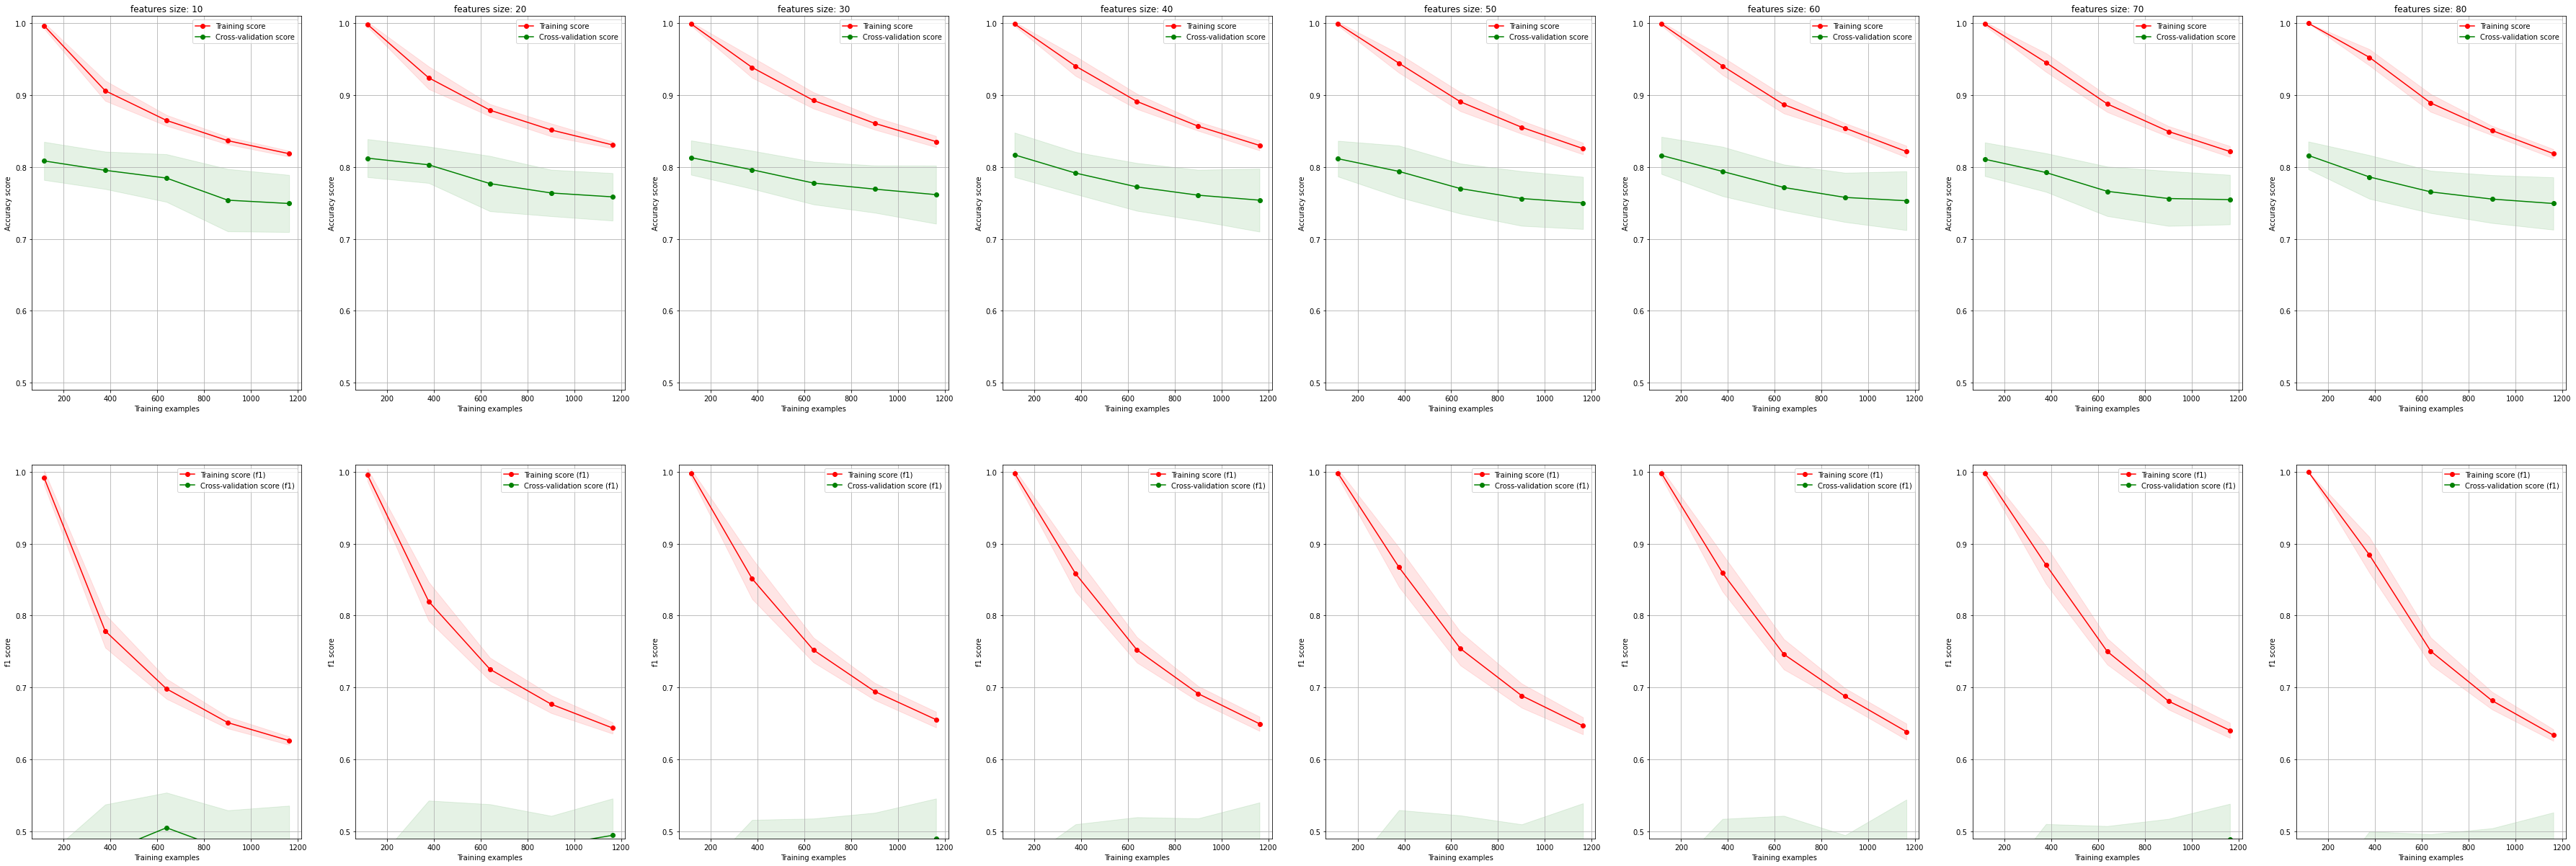

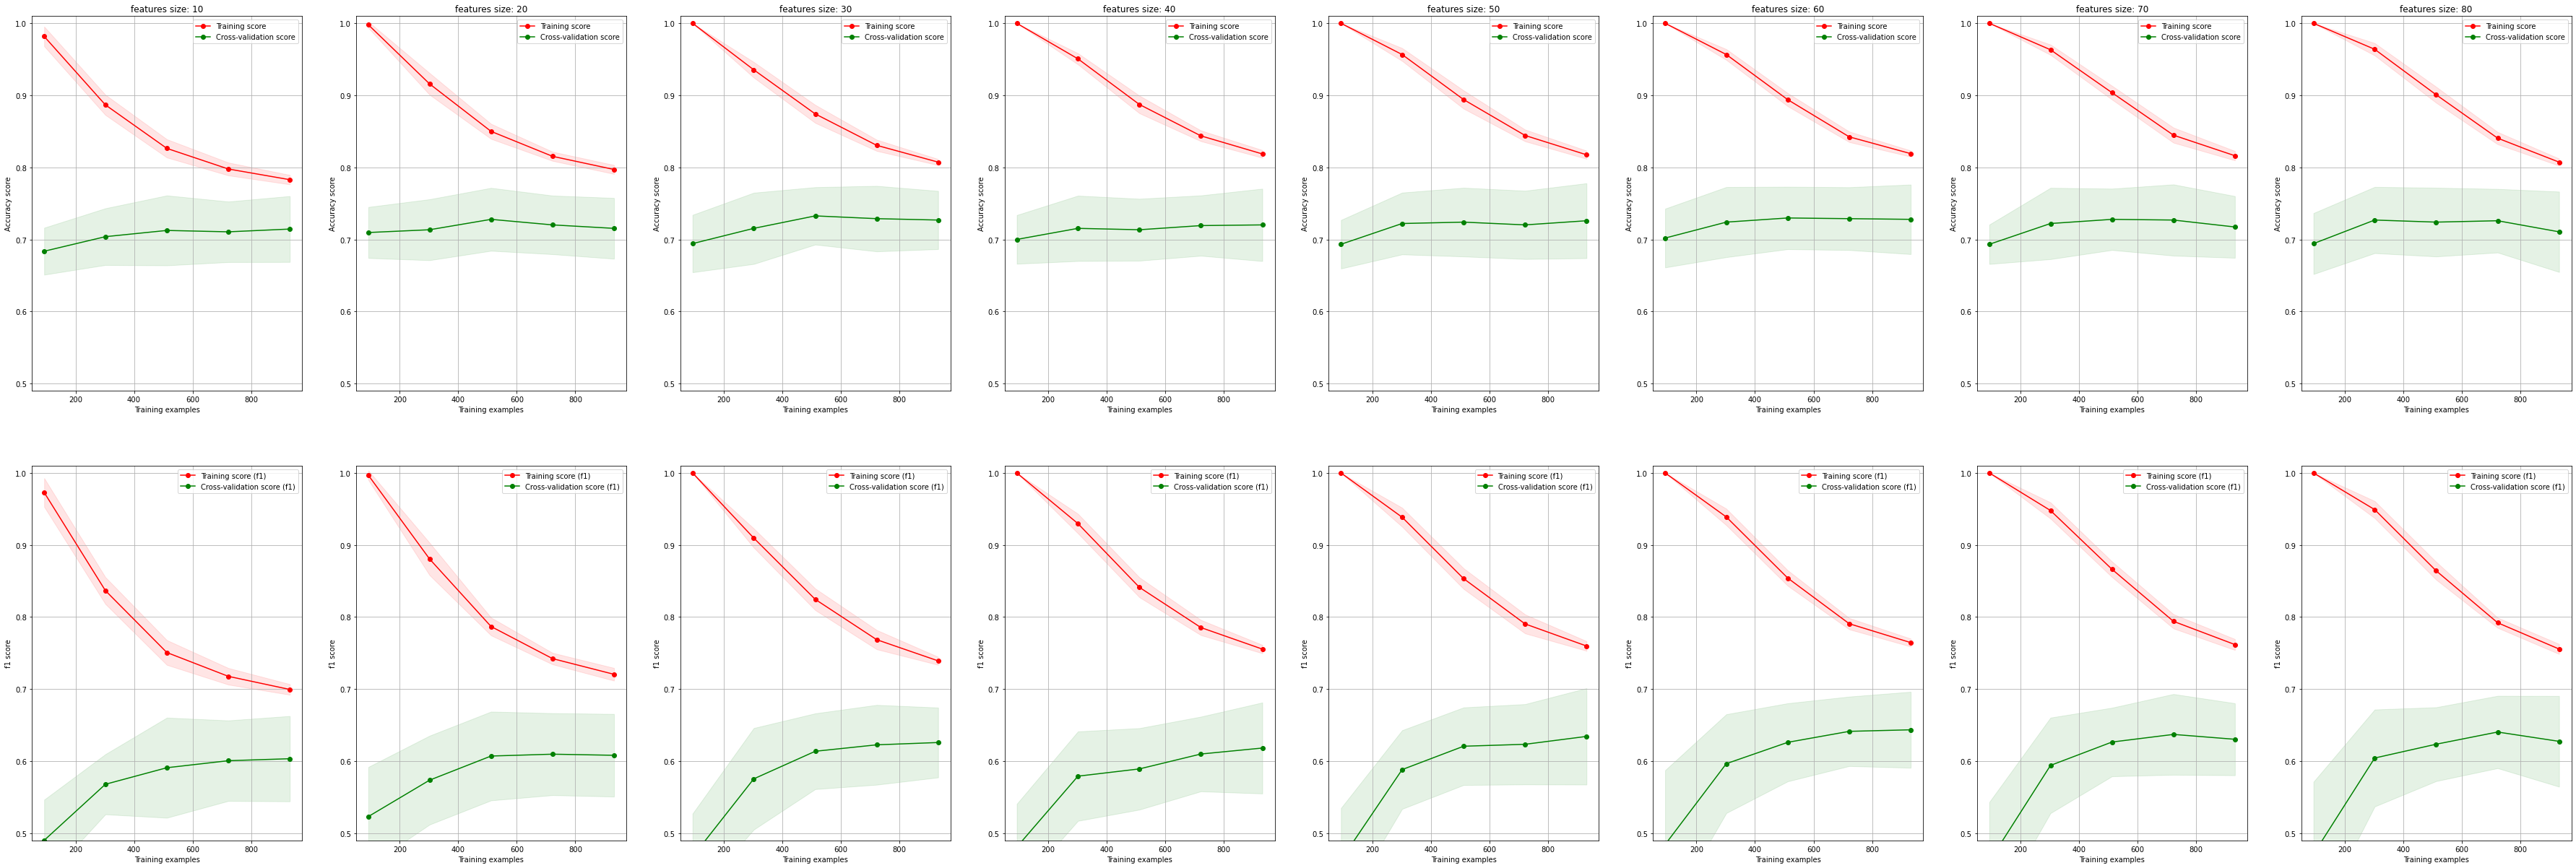

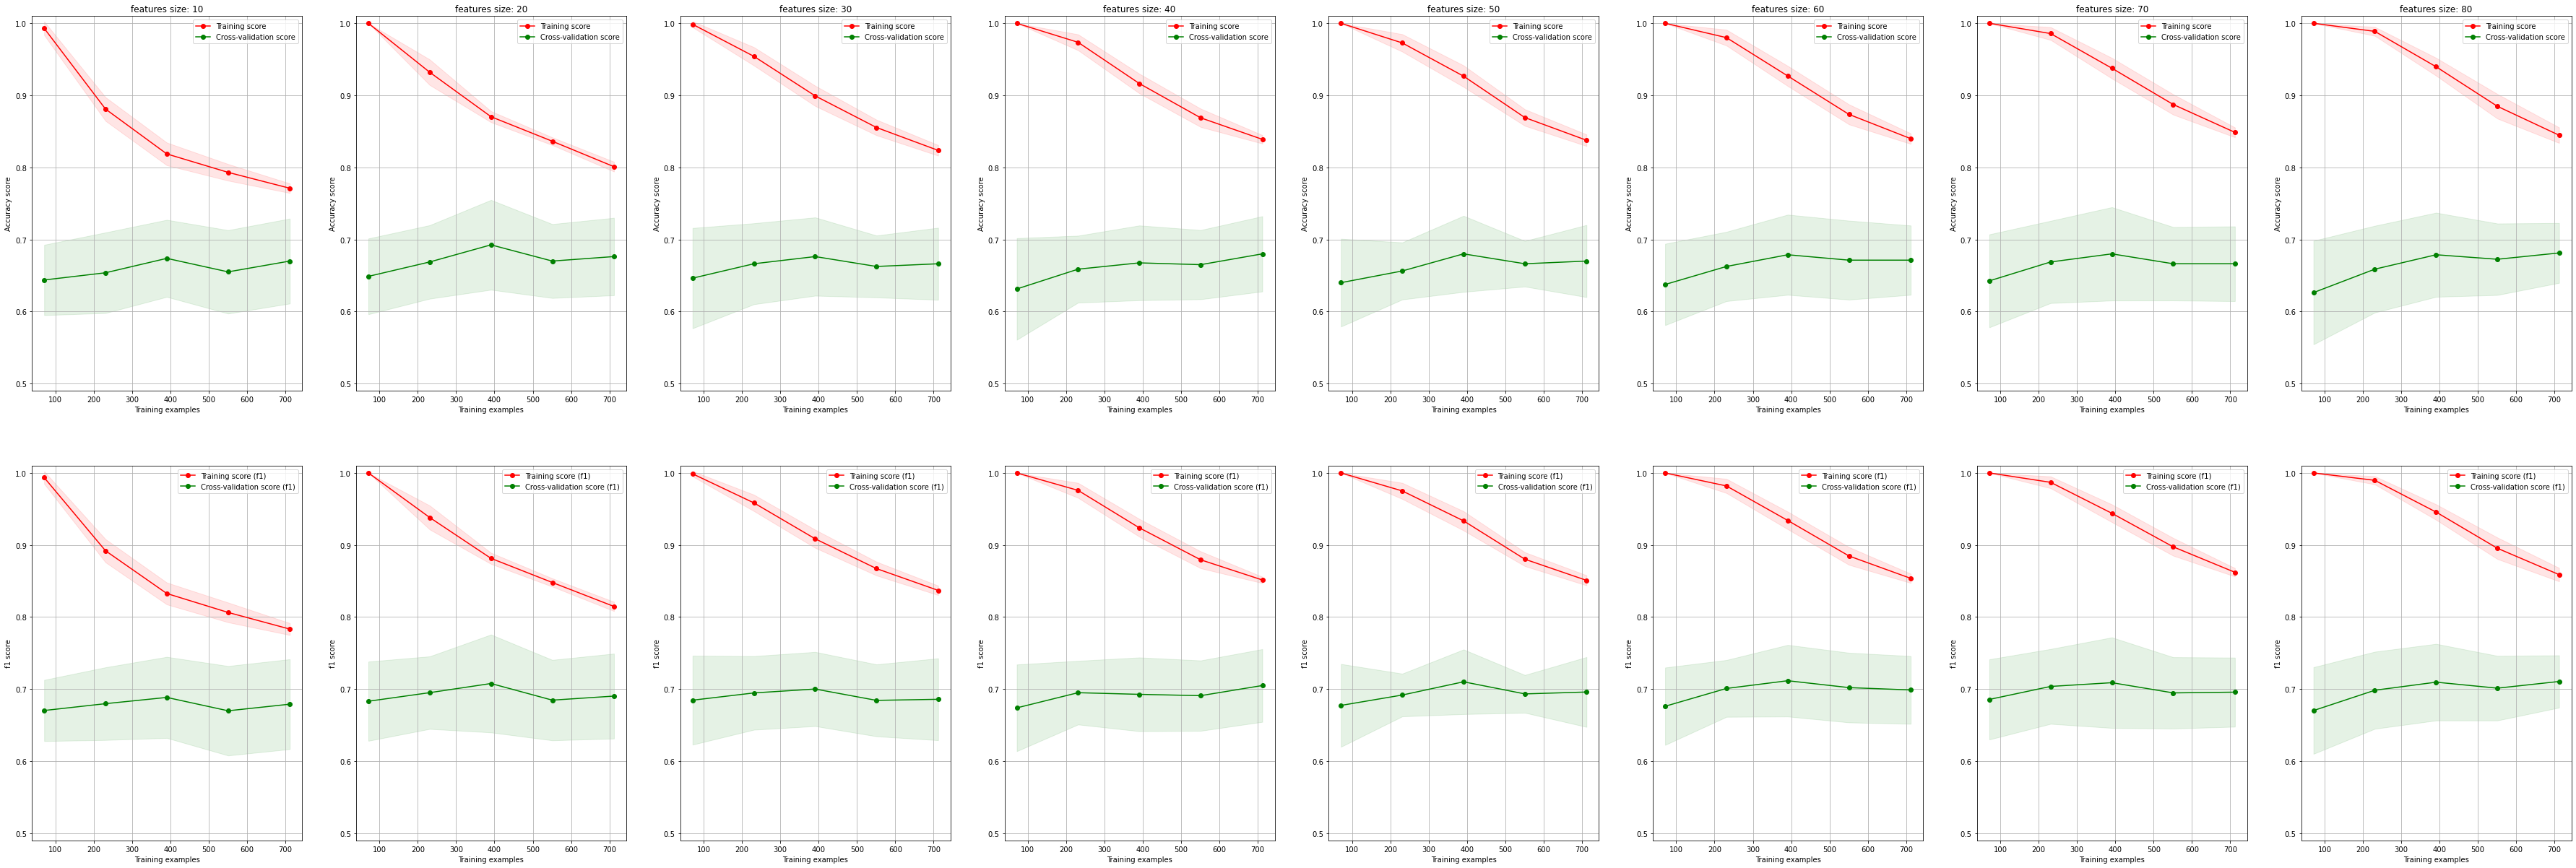

In [25]:
for year in tqdm(range(5, 16, 5)):  # 予後年数毎のループ
    # 特徴量選択から行うので特徴量選択前のデータから使用
    X = X_dict["basic"]["train"]["X{0:0=2}".format(year)]
    y = y_dict["basic"]["train"]["y{0:0=2}".format(year)]
    min_k = 10
    max_k = 80
    span = 10
    fig, axes = plt.subplots(2, (max_k - min_k) // span + 1, figsize=(63, 21))
    cv = StratifiedShuffleSplit(n_splits=10, random_state=SEED)

    for k in range(min_k, max_k + 1, span):
        # 特徴量選択するために、trainのデータを抽出
        X_train, _, y_train, _ = train_test_split(X, y, random_state=SEED, stratify=y)
        assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"

        result_chi2 = feature_selection(X_train, y_train, chi2, "k_best", k)
        features = list(result_chi2[result_chi2["False: dropped"]].index)
        title = "features size: {0}".format(len(features))

        params = {
            "n_estimators": 500,
            "criterion": "entropy",
            "max_depth": 5,
            "max_leaf_nodes": 20,
            "max_features": "log2",
            "class_weight": "balanced",
            "random_state": SEED,
        }
        estimator = RandomForestClassifier(**params)

        # cvをplot_learning_curve内で実施するので、X(y)_trainは使用しない
        plot_learning_curve(
            estimator,
            title,
            X[features],
            y,
            axes=axes[:, k // span - 1],
            ylim=(0.49, 1.01),
            cv=cv,
            n_jobs=4,
            scoring="accuracy",
        )
    make_dir(
        config.FIGURES_MODELS_PROGNOSIS_CROSS_DIR + "/learning_curve/basic/chi2"
    )
    plt.savefig(
        config.FIGURES_MODELS_PROGNOSIS_CROSS_DIR
        + "/learning_curve/basic/chi2/X{0:0=2}.png".format(year)
    )

### mrmr

100%|██████████████████████████████████████████████████████| 3/3 [25:14<00:00, 504.87s/it]


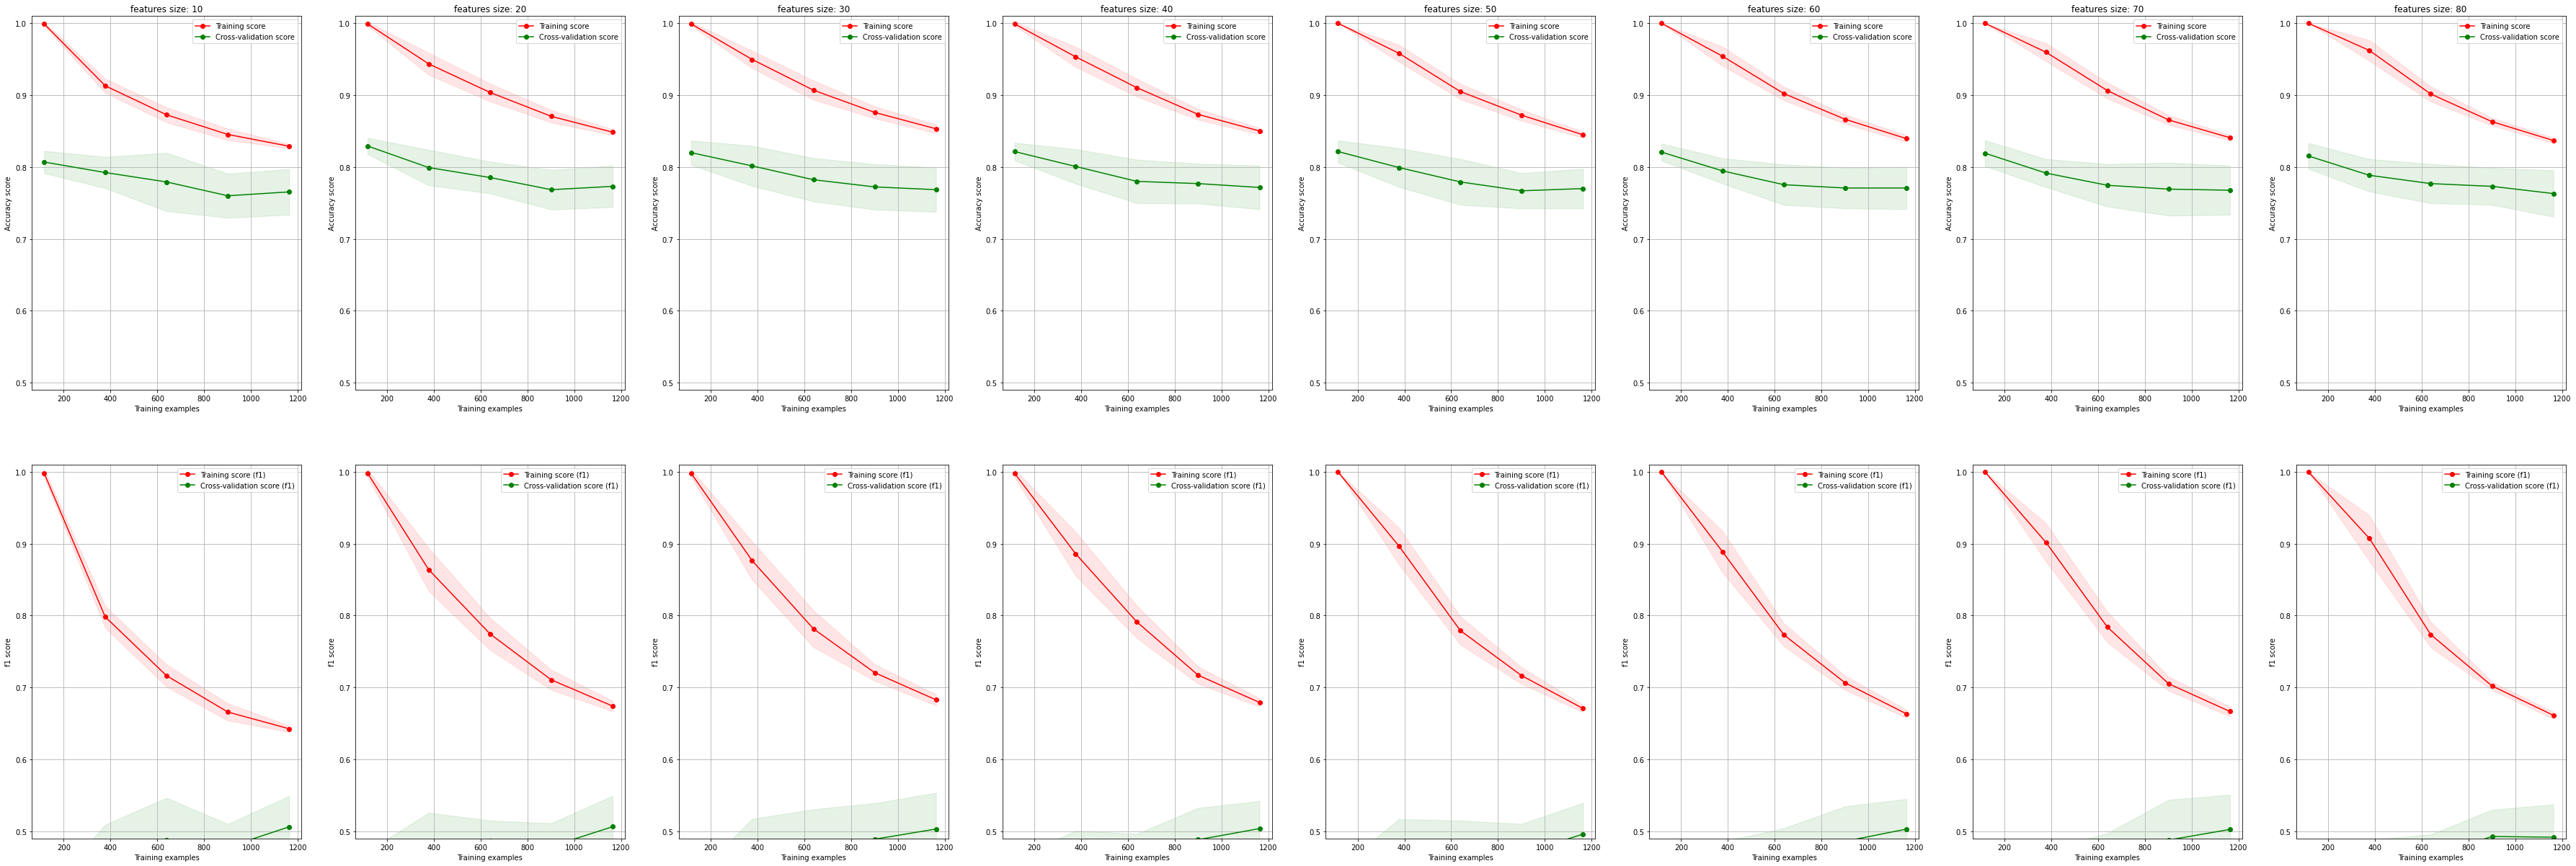

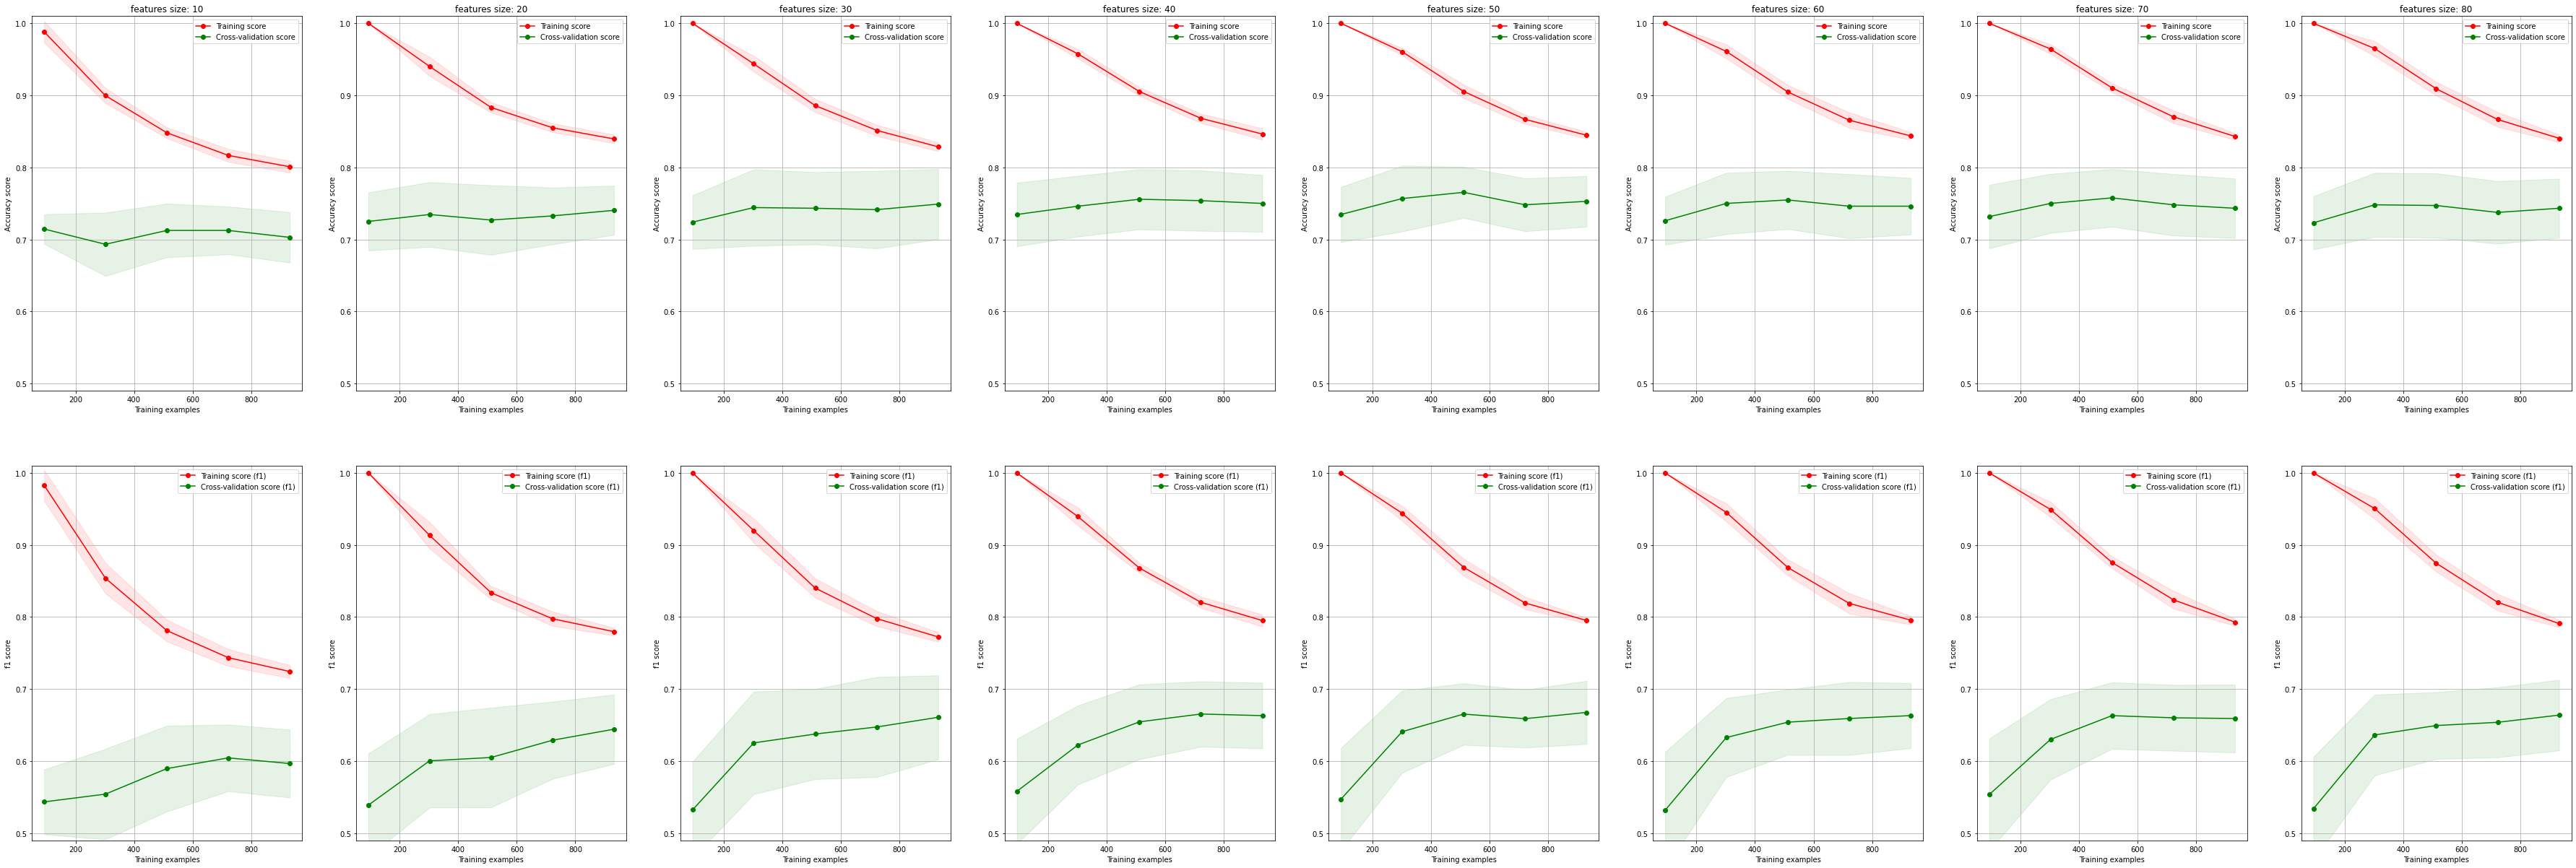

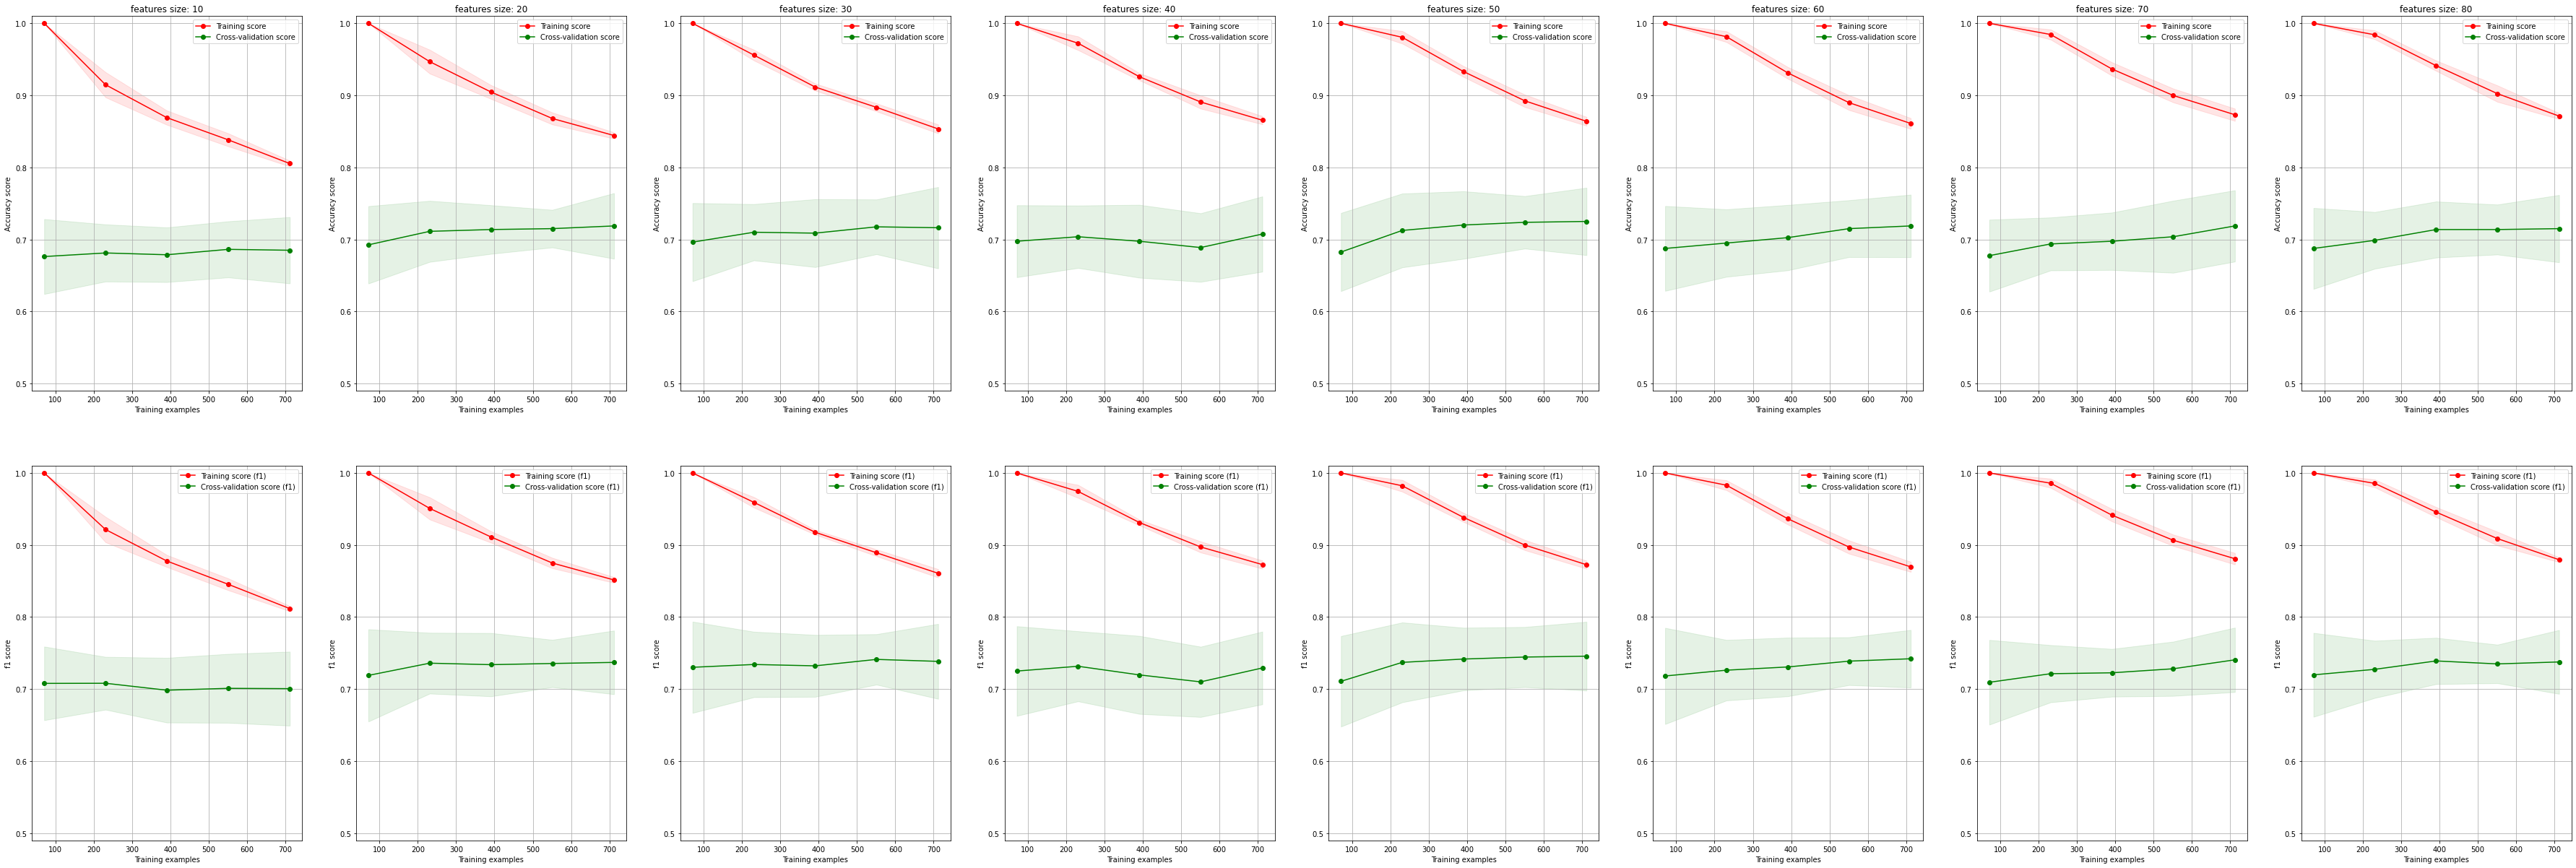

In [27]:
for year in tqdm(range(5, 16, 5)):  # 予後年数毎のループ
    # 特徴量選択から行うので特徴量選択前のデータから使用
    X = X_dict["basic"]["train"]["X{0:0=2}".format(year)]
    y = y_dict["basic"]["train"]["y{0:0=2}".format(year)]
    min_k = 10
    max_k = 80
    span = 10
    fig, axes = plt.subplots(2, (max_k - min_k) // span + 1, figsize=(63, 21))
    cv = StratifiedShuffleSplit(n_splits=10, random_state=SEED)

    for k in range(min_k, max_k + 1, span):
        # 特徴量選択するために、trainのデータを抽出
        X_train, _, y_train, _ = train_test_split(X, y, random_state=SEED, stratify=y)
        assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"

        features = mrmr.mrmr_classif(
            X=X_train,
            y=y_train,
            K=k,
            show_progress=False,
        )
        title = "features size: {0}".format(len(features))

        params = {
            "n_estimators": 500,
            "criterion": "entropy",
            "max_depth": 5,
            "max_leaf_nodes": 20,
            "max_features": "log2",
            "class_weight": "balanced",
            "random_state": SEED,
        }
        estimator = RandomForestClassifier(**params)

        # cvをplot_learning_curve内で実施するので、X(y)_trainは使用しない
        plot_learning_curve(
            estimator,
            title,
            X[features],
            y,
            axes=axes[:, k // span - 1],
            ylim=(0.49, 1.01),
            cv=cv,
            n_jobs=4,
            scoring="accuracy",
        )
    make_dir(
        config.FIGURES_MODELS_PROGNOSIS_CROSS_DIR + "/learning_curve/basic/mrmr"
    )
    plt.savefig(
        config.FIGURES_MODELS_PROGNOSIS_CROSS_DIR
        + "/learning_curve/basic/mrmr/X{0:0=2}.png".format(year)
    )

### boruta

  0%|                                                               | 0/3 [00:00<?, ?it/s]/root/miniconda3/envs/breast-cancer-analytics/lib/python3.8/site-packages/boruta/boruta_py.py:260: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dec_reg = np.zeros(n_feat, dtype=np.int)
/root/miniconda3/envs/breast-cancer-analytics/lib/python3.8/site-packages/boruta/boruta_py.py:263: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When

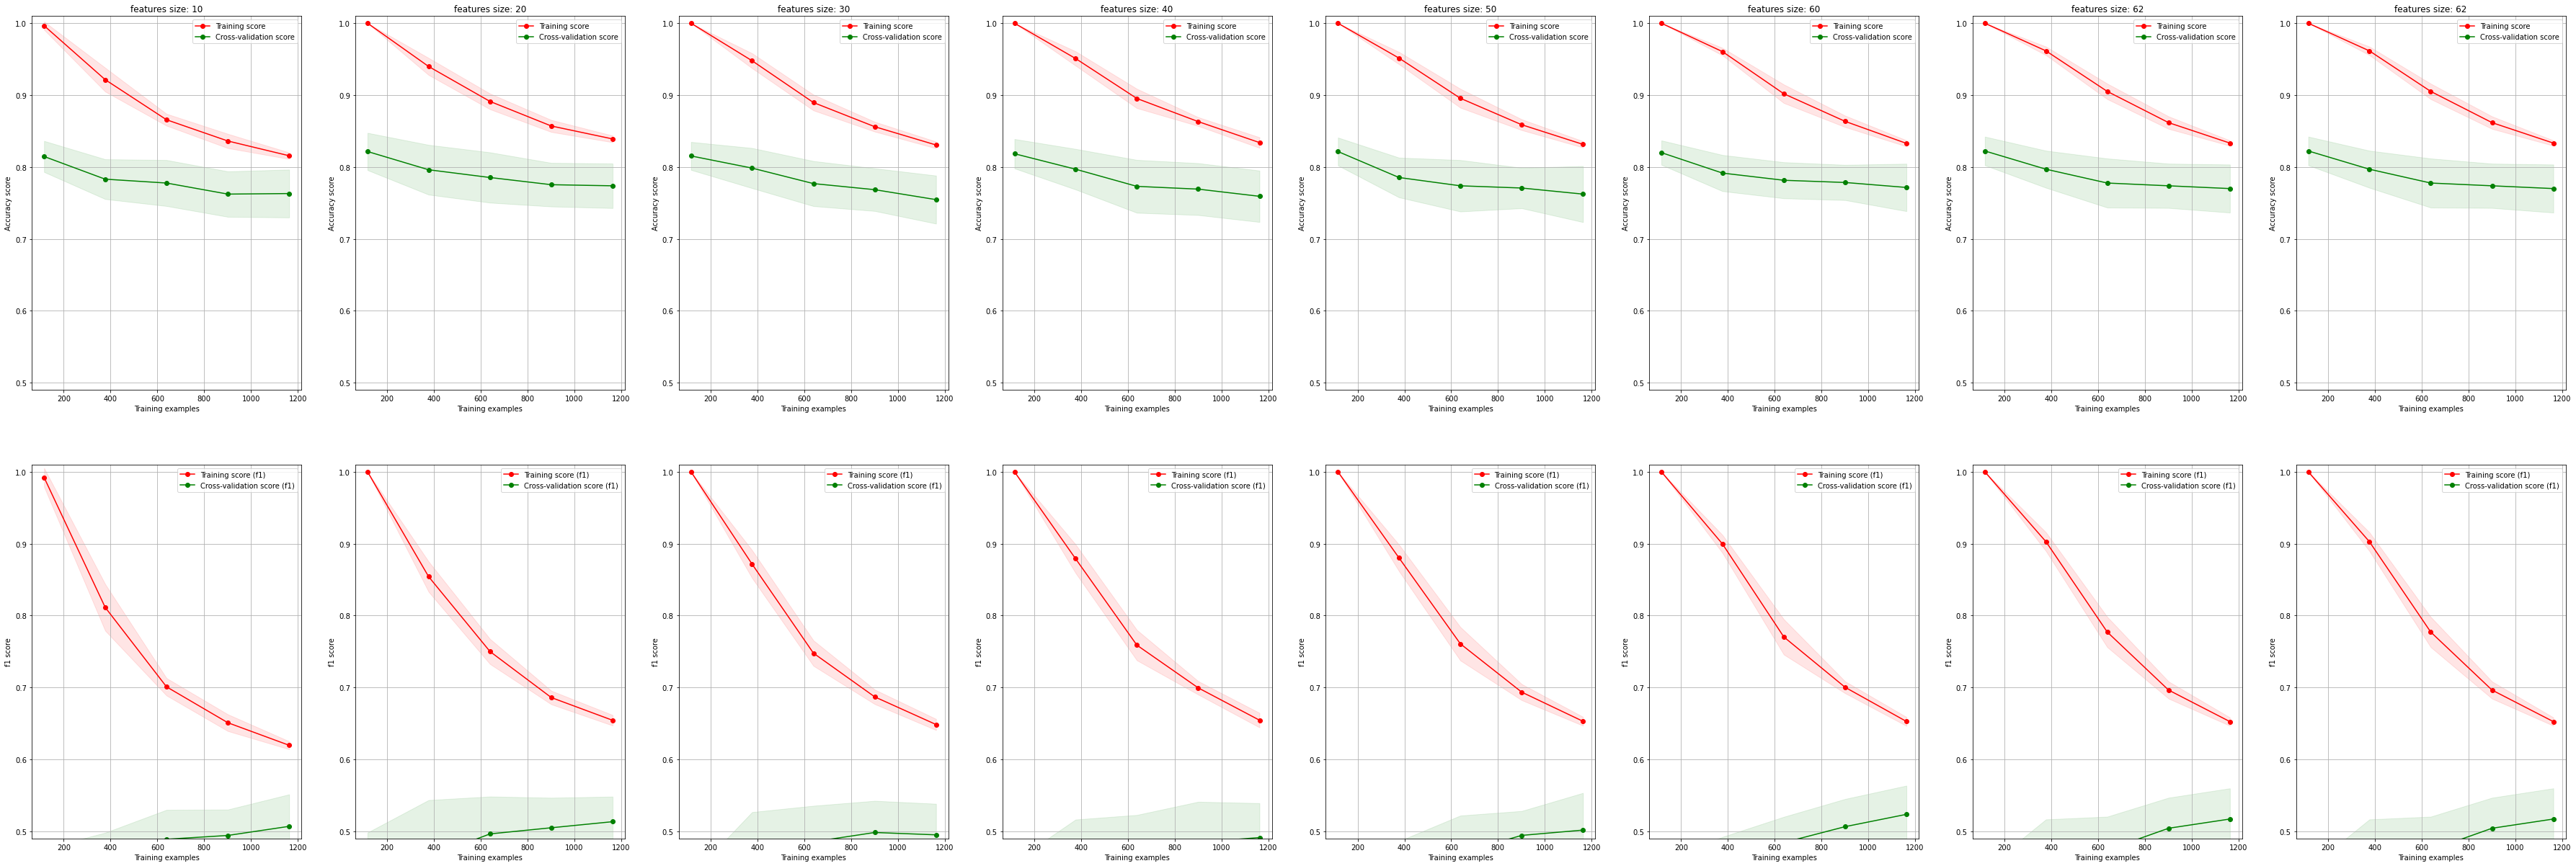

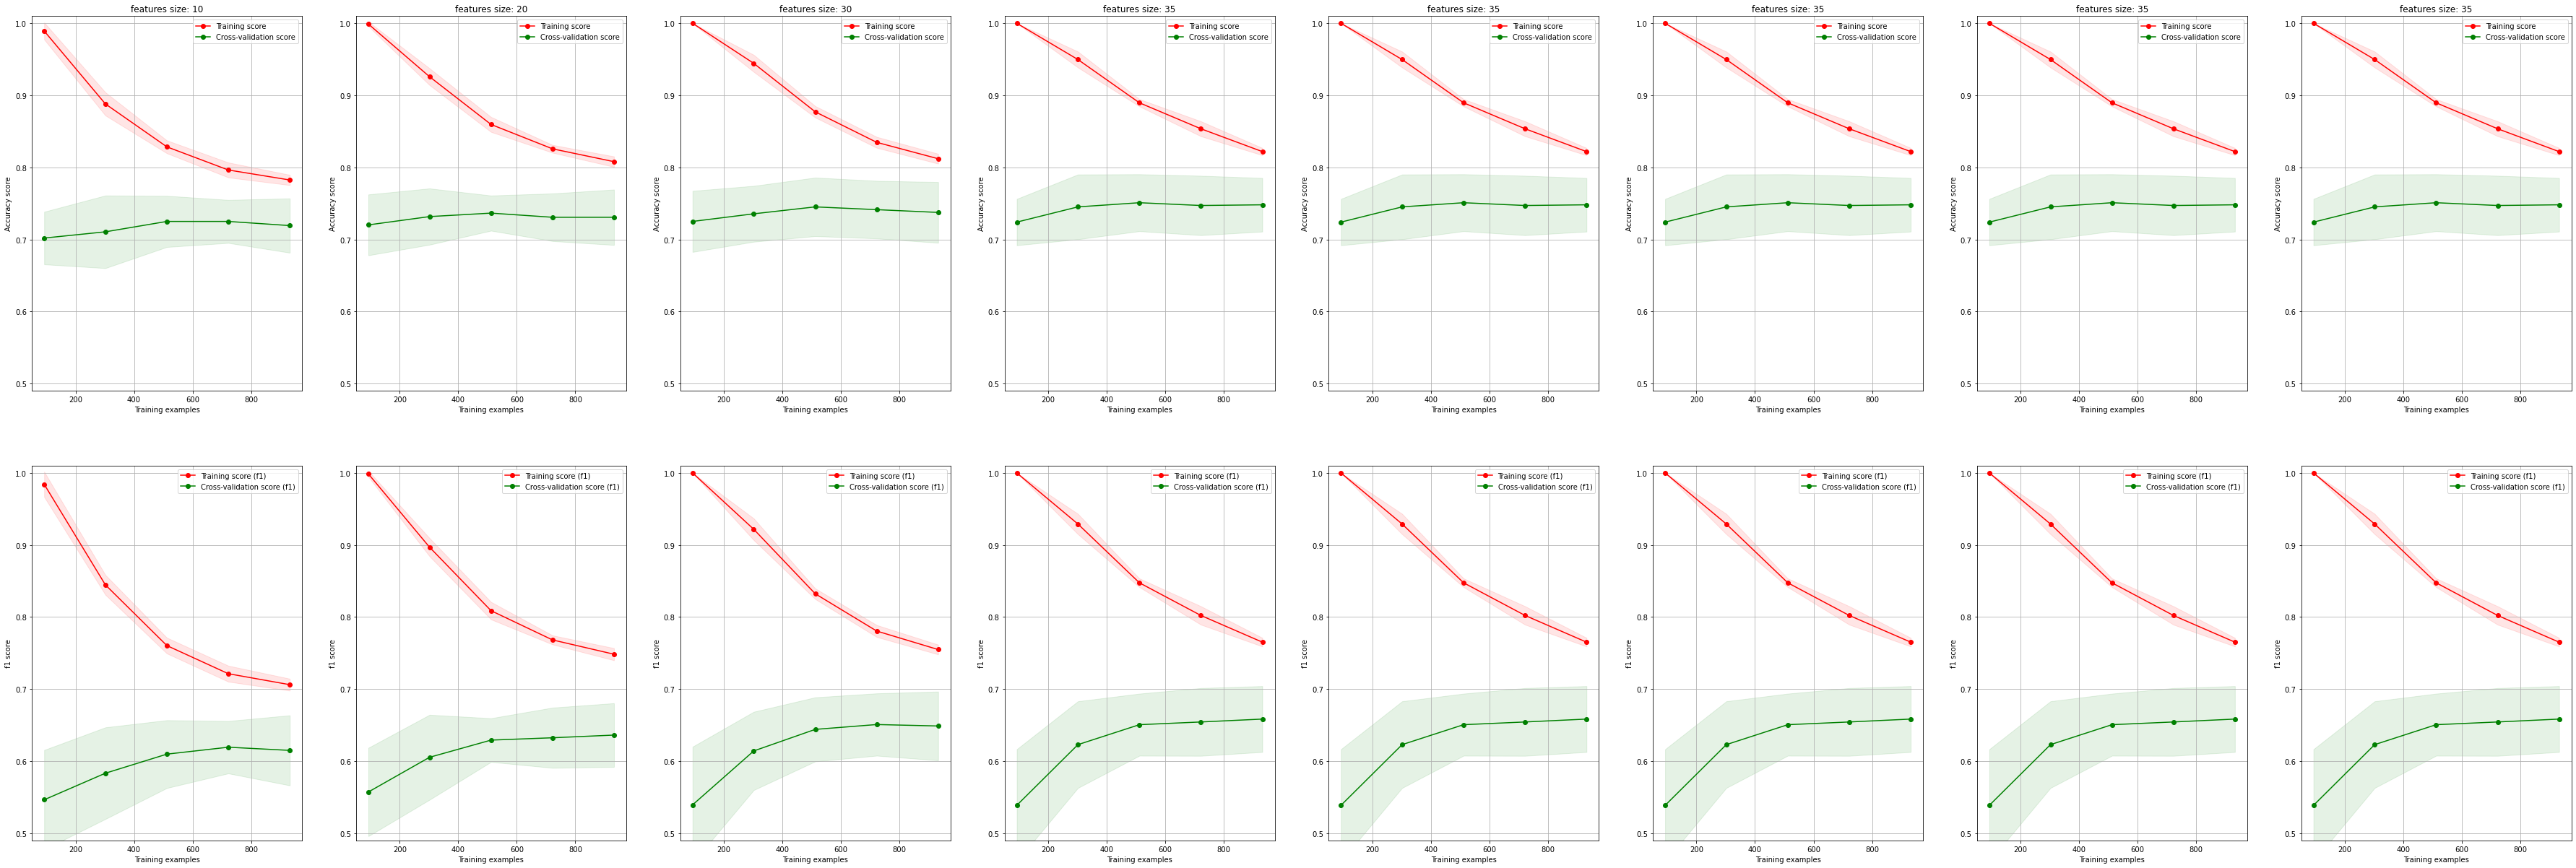

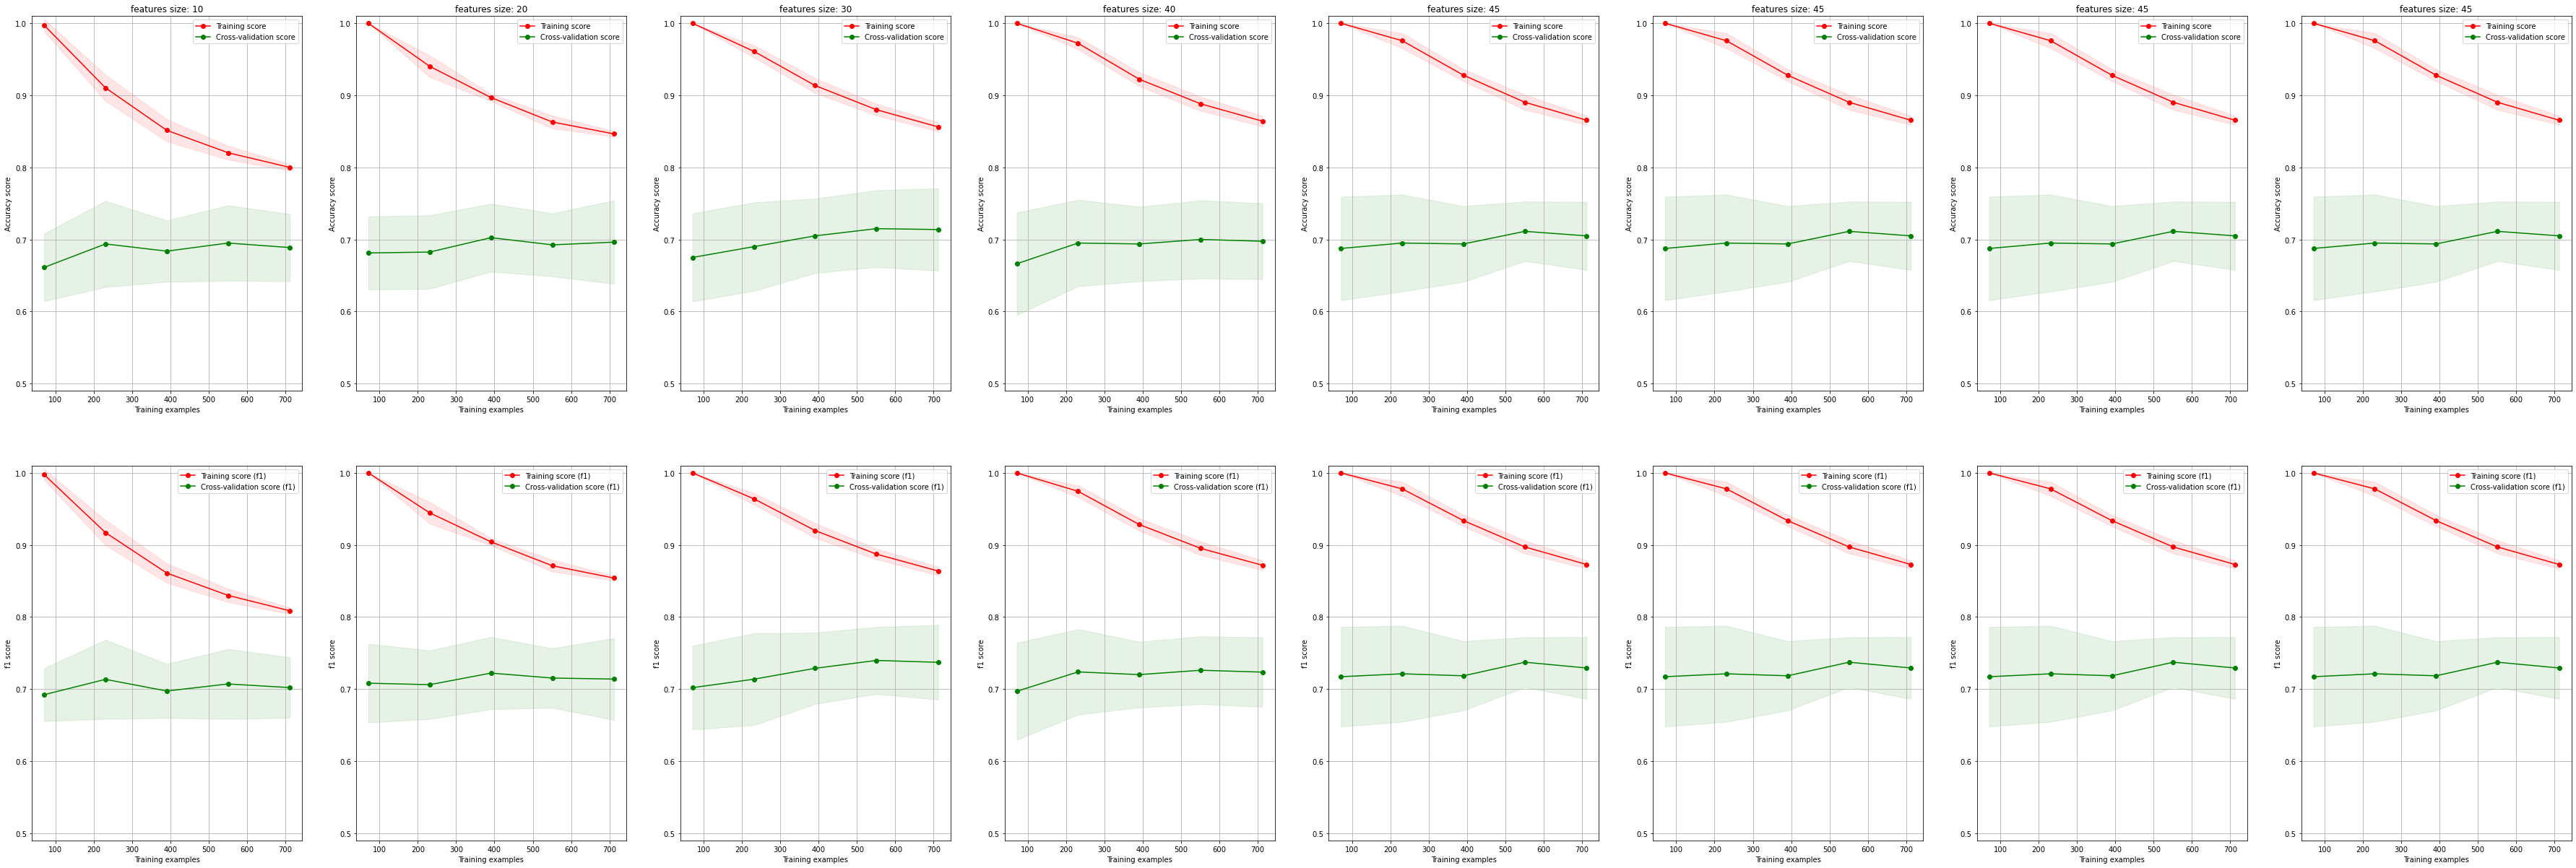

In [33]:
for year in tqdm(range(5, 16, 5)):  # 予後年数毎のループ
    # 特徴量選択から行うので特徴量選択前のデータから使用
    X = X_dict["basic"]["train"]["X{0:0=2}".format(year)]
    y = y_dict["basic"]["train"]["y{0:0=2}".format(year)]
    min_k = 10
    max_k = 80
    span = 10
    fig, axes = plt.subplots(2, (max_k - min_k) // span + 1, figsize=(63, 21))
    cv = StratifiedShuffleSplit(n_splits=10, random_state=SEED)

    for k in range(min_k, max_k + 1, span):
        # 特徴量選択するために、trainのデータを抽出
        X_train, _, y_train, _ = train_test_split(X, y, random_state=SEED, stratify=y)
        assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"

        # RandomForestClassifierでBorutaを実行
        rf = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=SEED)
        feat_selector = BorutaPy(rf, n_estimators="auto", verbose=0, random_state=SEED)
        feat_selector.fit(
            X_train.values,
            y_train.values,
        )
        # 選択された特徴量を確認
        features = X_train.columns[feat_selector.support_][:k]

        title = "features size: {0}".format(len(features))

        params = {
            "n_estimators": 500,
            "criterion": "entropy",
            "max_depth": 5,
            "max_leaf_nodes": 20,
            "max_features": "log2",
            "class_weight": "balanced",
            "random_state": SEED,
        }
        estimator = RandomForestClassifier(**params)

        # cvをplot_learning_curve内で実施するので、X(y)_trainは使用しない
        plot_learning_curve(
            estimator,
            title,
            X[features],
            y,
            axes=axes[:, k // span - 1],
            ylim=(0.49, 1.01),
            cv=cv,
            n_jobs=4,
            scoring="accuracy",
        )
    make_dir(
        config.FIGURES_MODELS_PROGNOSIS_CROSS_DIR + "/learning_curve/basic/boruta"
    )
    plt.savefig(
        config.FIGURES_MODELS_PROGNOSIS_CROSS_DIR
        + "/learning_curve/basic/boruta/X{0:0=2}.png".format(year)
    )

以下のコードはまだ修正していないので、エラーになります（辞書のキーが異なる）

## subtype毎のベースライン・学習

### borutaを使用した場合のベースライン・基本学習結果

In [ ]:
for year in range(5, 16, 5):  # 予後年数毎のループ
    print("====={0:0=2}".format(year) * 10)

    for subtype in pd.read_pickle(
        config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/df_cross.pkl"
    )["CLAUDIN_SUBTYPE"].unique():
        X_train = X_dict["chi2"]["claudin_subtype"]["train"][
            "X{0:0=2}_{1}".format(year, subtype)
        ]
        y_train = y_dict["chi2"]["claudin_subtype"]["train"][
            "y{0:0=2}_{1}".format(year, subtype)
        ]
        X_test = X_dict["chi2"]["claudin_subtype"]["test"][
            "X{0:0=2}_{1}".format(year, subtype)
        ]
        y_test = y_dict["chi2"]["claudin_subtype"]["test"][
            "y{0:0=2}_{1}".format(year, subtype)
        ]
        assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"
        assert X_test.shape[0] == y_test.shape[0], "test size is incorrect"

        # accuracyの表示
        print("----------" * 10)
        print("subtype: ", subtype)
        print("予後年数：{0:0=2}年:".format(year))
        if accuracy_score(y_train, np.zeros(len(y_train))) >= 0.5:
            score = (
                "0>1".format(year),
                round(accuracy_score(y_train, np.zeros(len(y_train))), 3),
            )
        else:
            score = (
                "0>1".format(year),
                round(accuracy_score(y_train, np.ones(len(y_train))), 3),
            )
        print("accuracyベースライン：", score)
        print("使用特徴量：", X_train.columns)
        print("学習サンプルサイズ：", X_train.shape)
        display("ラベル比率：", y_train.value_counts())
        display(compare_bcms(X_train, y_train))

# 最適化

分類器を学習させ、パラメータのチューニングを行い、高い予測精度を目指す。

## optuna

モデルのパラメータをベイズ最適化に基づいて最適化していくoptunaを使用する

### Random Forest

In [ ]:
def objective(trial):
    # ランダムフォレストのパラメータチューニング
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "criterion": trial.suggest_categorical(
            "criterion", ["gini", "entropy", "log_loss"]
        ),
        "max_depth": trial.suggest_int("max_depth", 2, 50, log=True),
        "max_leaf_noddes": trial.suggest_int("max_leaf_nodes", 2, 100),
        "max_features": trial.suggest_categorical(
            "max_features", ["sqrt", "log2", None]
        ),
        "random_state": SEED,
    }

    clf = RandomForestClassifier(**params)
    # 10分割交差検証によるテストデータのaccuracyの出力
    score = cross_val_score(
        clf, X_train, y_train, n_jobs=-1, cv=10, scoring=make_scorer(f1_score)
    )
    accuracy = score.mean()
    return accuracy

In [ ]:
def objective(trial):
    # ロジスティック回帰のパラメータチューニング
    params = {
        "penalty ": "l2",
        "C": trial.suggest_float("C", 1e-5, 100),
        "solver": trial.suggest_categorical(
            "solver", ["newton-cg", "lbfgs", "sag", "saga"]
        ),
        "random_state": SEED,
    }

    clf = LogisticRegression(
        penalty="l2",
        C=C,
        solver=solver,
        random_state=SEED,
    )
    # 10分割交差検証によるテストデータのaccuracyの出力
    score = cross_val_score(
        clf, X_train, y_train, n_jobs=-1, cv=10, scoring=make_scorer(f1_score)
    )
    accuracy = score.mean()
    return accuracy

In [ ]:
def objective(trial):
    # SVMのパラメータチューニング
    params = {
        "C": trial.suggest_float("C", 1e-5, 100),
        "kernel": trial.suggest_categorical(
            "kernel", ["linear", "poly", "rbf", "sigmoid"]
        ),
        "decision_function_shape": trial.suggest_categorical(
            "decision_function_shape", ["ovo", "ovr"]
        ),
    }

    clf = SVC(**params)
    # 10分割交差検証によるテストデータのaccuracyの出力
    score = cross_val_score(
        clf, X_train, y_train, n_jobs=-1, cv=10, scoring=make_scorer(f1_score)
    )
    accuracy = score.mean()
    return accuracy

#### 全サンプルでの予測(boruta)

In [ ]:
year = 15
X_train = X_dict["chi2"]["boruta"]["train"][prognosis_Xlabel]
y_train = y_dict["chi2"]["boruta"]["train"][prognosis_ylabel]
X_test = X_dict["chi2"]["boruta"]["test"][prognosis_Xlabel]
y_test = y_dict["chi2"]["boruta"]["test"][prognosis_ylabel]

study = optuna.create_study(
    direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED)
)
study.optimize(objective, n_trials=100)

In [ ]:
# 最も良いパラメータ
print(f"The best value is : \n {study.best_value}")
print(f"The best parameters are : \n {study.best_params}")

In [20]:
print("tuning前")
rf = RandomForestClassifier(random_state=SEED)
rf.fit(X_train, y_train)
pred_tmp = rf.predict(X_test)
show_scores(y_test, pred_tmp)

print("tuning後")
rf = RandomForestClassifier(
    n_estimators=705,
    criterion="entropy",
    max_depth=2,
    max_leaf_nodes=13,
    max_features="log2",
    random_state=SEED,
)
rf.fit(X_train, y_train)
pred_tmp = rf.predict(X_test)
show_scores(y_test, pred_tmp)

tuning前
accuracy:  0.6317829457364341
precision:  0.6287425149700598
recall:  0.7608695652173914
f1 score:  0.6885245901639344
tuning後
accuracy:  0.6782945736434108
precision:  0.6589595375722543
recall:  0.8260869565217391
f1 score:  0.7331189710610932


## subtype毎の予測

In [23]:
for year in range(5, 16, 5):  # 予後年数毎のループ
    print("====={0:0=2}".format(year) * 10)

    for st in pd.read_pickle(
        config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/df_cross.pkl"
    )["CLAUDIN_SUBTYPE"].unique():
        print("-----" * 10)
        print(st)
        prognosis_Xlabel = "X{0:0=2}_{1}".format(year, st)
        prognosis_ylabel = "y{0:0=2}_{1}".format(year, st)

        X_train = X_dict["chi2"]["claudin_subtype"]["train"][prognosis_Xlabel]
        y_train = y_dict["chi2"]["claudin_subtype"]["train"][prognosis_ylabel]
        X_test = X_dict["chi2"]["claudin_subtype"]["test"][prognosis_Xlabel]
        y_test = y_dict["chi2"]["claudin_subtype"]["test"][prognosis_ylabel]

        assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"
        assert X_test.shape[0] == y_test.shape[0], "test size is incorrect"

        print("tuning前")
        rf = RandomForestClassifier(random_state=SEED)
        rf.fit(X_train, y_train)
        pred_tmp = rf.predict(X_test)
        show_scores(y_test, pred_tmp)

        print("tuning後")
        rf = RandomForestClassifier(
            n_estimators=705,
            criterion="entropy",
            max_depth=2,
            max_leaf_nodes=13,
            max_features="log2",
            random_state=SEED,
        )
        rf.fit(X_train, y_train)
        pred_tmp = rf.predict(X_test)
        show_scores(y_test, pred_tmp)

=====05=====05=====05=====05=====05=====05=====05=====05=====05=====05
--------------------------------------------------
claudin-low
tuning前
accuracy:  0.7954545454545454
precision:  0.0
recall:  0.0
f1 score:  0.0
tuning後
accuracy:  0.8181818181818182
precision:  0.0
recall:  0.0
f1 score:  0.0
--------------------------------------------------
LumA
tuning前
accuracy:  0.9328859060402684
precision:  0.0
recall:  0.0
f1 score:  0.0
tuning後


/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.9328859060402684
precision:  0.0
recall:  0.0
f1 score:  0.0
--------------------------------------------------
LumB
tuning前
accuracy:  0.8173913043478261
precision:  0.0
recall:  0.0
f1 score:  0.0
tuning後


/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.8347826086956521
precision:  0.0
recall:  0.0
f1 score:  0.0
--------------------------------------------------
Her2
tuning前
accuracy:  0.6862745098039216
precision:  0.5714285714285714
recall:  0.4444444444444444
f1 score:  0.5
tuning後


/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.6470588235294118
precision:  0.5
recall:  0.16666666666666666
f1 score:  0.25
--------------------------------------------------
Normal
tuning前
accuracy:  0.7714285714285715
precision:  0.25
recall:  0.5
f1 score:  0.3333333333333333
tuning後
accuracy:  0.7428571428571429
precision:  0.14285714285714285
recall:  0.25
f1 score:  0.18181818181818182
--------------------------------------------------
Basal
tuning前
accuracy:  0.4523809523809524
precision:  0.3
recall:  0.15789473684210525
f1 score:  0.20689655172413793
tuning後
accuracy:  0.47619047619047616
precision:  0.2857142857142857
recall:  0.10526315789473684
f1 score:  0.15384615384615385
=====10=====10=====10=====10=====10=====10=====10=====10=====10=====10
--------------------------------------------------
claudin-low
tuning前
accuracy:  0.6
precision:  0.375
recall:  0.25
f1 score:  0.3
tuning後
accuracy:  0.6571428571428571
precision:  0.5
recall:  0.16666666666666666
f1 score:  0.25
----------------------------------

/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.5913978494623656
precision:  0.37037037037037035
recall:  0.3225806451612903
f1 score:  0.3448275862068965
--------------------------------------------------
Her2
tuning前
accuracy:  0.5106382978723404
precision:  0.5
recall:  0.6521739130434783
f1 score:  0.5660377358490566
tuning後
accuracy:  0.5319148936170213
precision:  0.5142857142857142
recall:  0.782608695652174
f1 score:  0.6206896551724138
--------------------------------------------------
Normal
tuning前
accuracy:  0.6666666666666666
precision:  0.4444444444444444
recall:  0.5714285714285714
f1 score:  0.5
tuning後
accuracy:  0.7083333333333334
precision:  0.5
recall:  0.7142857142857143
f1 score:  0.588235294117647
--------------------------------------------------
Basal
tuning前
accuracy:  0.5
precision:  0.6666666666666666
recall:  0.34782608695652173
f1 score:  0.4571428571428571
tuning後
accuracy:  0.5526315789473685
precision:  0.8
recall:  0.34782608695652173
f1 score:  0.48484848484848486
=====15=====15=====15

### lightGBM

In [24]:
from lightgbm import LGBMClassifier


def objective(trial):
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "max_bin": trial.suggest_int("max_bin", 100, 300),
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
    }
    clf = LGBMClassifier(boosting_type="gbdt", **params, random_state=SEED)
    # 10分割交差検証によるテストデータのaccuracyの出力
    score = cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=10)
    accuracy = score.mean()
    return accuracy


year = 15
X_train = X_dict["chi2"]["boruta"]["train"]["X{0:0=2}".format(year)]
y_train = y_dict["chi2"]["boruta"]["train"]["y{0:0=2}".format(year)]
X_test = X_dict["chi2"]["boruta"]["test"]["X{0:0=2}".format(year)]
y_test = y_dict["chi2"]["boruta"]["test"]["y{0:0=2}".format(year)]

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2022-08-16 22:31:25,893] A new study created in memory with name: no-name-d85cb0b1-eb61-4dda-8688-2cd171712a05
[I 2022-08-16 22:31:27,395] Trial 0 finished with value: 0.6400030111412225 and parameters: {'lambda_l1': 1.734223168041933e-05, 'lambda_l2': 1.1228551678336792e-07, 'max_bin': 224, 'num_leaves': 38, 'learning_rate': 0.09023530287571588, 'n_estimators': 66}. Best is trial 0 with value: 0.6400030111412225.
[I 2022-08-16 22:31:28,265] Trial 1 finished with value: 0.6436766034327009 and parameters: {'lambda_l1': 0.024522717103743746, 'lambda_l2': 0.001563943840163855, 'max_bin': 143, 'num_leaves': 22, 'learning_rate': 0.004336637489615775, 'n_estimators': 626}. Best is trial 1 with value: 0.6436766034327009.
[I 2022-08-16 22:31:28,517] Trial 2 finished with value: 0.6424269798253538 and parameters: {'lambda_l1': 3.32260152568701e-07, 'lambda_l2': 6.314841123584675e-05, 'max_bin': 140, 'num_leaves': 34, 'learning_rate': 0.0034432967594071524, 'n_estimators': 209}. Best is trial

[LightGBM] [Warning] lambda_l1 is set=1.734223168041933e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.734223168041933e-05
[LightGBM] [Warning] lambda_l2 is set=1.1228551678336792e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1228551678336792e-07
[LightGBM] [Warning] lambda_l1 is set=0.024522717103743746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024522717103743746
[LightGBM] [Warning] lambda_l2 is set=0.001563943840163855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001563943840163855
[LightGBM] [Warning] lambda_l1 is set=0.024522717103743746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024522717103743746
[LightGBM] [Warning] lambda_l2 is set=0.001563943840163855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001563943840163855
[LightGBM] [Warning] lambda_l1 is set=3.32260152568701e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.32260152568701e-07
[LightGBM] [Warning] lambda_l2 i

[I 2022-08-16 22:31:55,993] Trial 64 finished with value: 0.657226738934056 and parameters: {'lambda_l1': 5.556613589209316, 'lambda_l2': 0.0018790721590509962, 'max_bin': 132, 'num_leaves': 23, 'learning_rate': 0.016741615253923346, 'n_estimators': 522}. Best is trial 14 with value: 0.6609454983438723.
[I 2022-08-16 22:31:56,517] Trial 65 finished with value: 0.648584763625414 and parameters: {'lambda_l1': 2.1452059536661876, 'lambda_l2': 0.001902387830817249, 'max_bin': 107, 'num_leaves': 21, 'learning_rate': 0.018380954342557272, 'n_estimators': 578}. Best is trial 14 with value: 0.6609454983438723.
[I 2022-08-16 22:31:56,921] Trial 66 finished with value: 0.6387383318277627 and parameters: {'lambda_l1': 4.4060578786248605, 'lambda_l2': 0.004448702317401843, 'max_bin': 131, 'num_leaves': 23, 'learning_rate': 0.013258137164486395, 'n_estimators': 502}. Best is trial 14 with value: 0.6609454983438723.


[LightGBM] [Warning] lambda_l1 is set=1.734223168041933e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.734223168041933e-05
[LightGBM] [Warning] lambda_l2 is set=1.1228551678336792e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1228551678336792e-07
[LightGBM] [Warning] lambda_l1 is set=1.734223168041933e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.734223168041933e-05
[LightGBM] [Warning] lambda_l2 is set=1.1228551678336792e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1228551678336792e-07
[LightGBM] [Warning] lambda_l1 is set=0.024522717103743746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024522717103743746
[LightGBM] [Warning] lambda_l2 is set=0.001563943840163855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001563943840163855
[LightGBM] [Warning] lambda_l1 is set=3.32260152568701e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.32260152568701e-07
[LightGBM] [Warning] lambd

[I 2022-08-16 22:31:57,825] Trial 67 finished with value: 0.6387684432399879 and parameters: {'lambda_l1': 0.447316449969109, 'lambda_l2': 0.025181933697597917, 'max_bin': 143, 'num_leaves': 25, 'learning_rate': 0.016356025622907767, 'n_estimators': 631}. Best is trial 14 with value: 0.6609454983438723.


[LightGBM] [Warning] lambda_l1 is set=1.734223168041933e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.734223168041933e-05
[LightGBM] [Warning] lambda_l2 is set=1.1228551678336792e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1228551678336792e-07
[LightGBM] [Warning] lambda_l1 is set=1.734223168041933e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.734223168041933e-05
[LightGBM] [Warning] lambda_l2 is set=1.1228551678336792e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1228551678336792e-07
[LightGBM] [Warning] lambda_l1 is set=0.024522717103743746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024522717103743746
[LightGBM] [Warning] lambda_l2 is set=0.001563943840163855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001563943840163855
[LightGBM] [Warning] lambda_l1 is set=0.024522717103743746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024522717103743746
[LightGBM] [Warning] lambd

[I 2022-08-16 22:31:58,328] Trial 68 finished with value: 0.6461607949412828 and parameters: {'lambda_l1': 1.1467411799207328, 'lambda_l2': 1.34920811434988e-06, 'max_bin': 121, 'num_leaves': 23, 'learning_rate': 0.008496867917375606, 'n_estimators': 435}. Best is trial 14 with value: 0.6609454983438723.


[LightGBM] [Warning] lambda_l1 is set=1.734223168041933e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.734223168041933e-05
[LightGBM] [Warning] lambda_l2 is set=1.1228551678336792e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1228551678336792e-07
[LightGBM] [Warning] lambda_l1 is set=0.024522717103743746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024522717103743746
[LightGBM] [Warning] lambda_l2 is set=0.001563943840163855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001563943840163855
[LightGBM] [Warning] lambda_l1 is set=3.32260152568701e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.32260152568701e-07
[LightGBM] [Warning] lambda_l2 is set=6.314841123584675e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.314841123584675e-05
[LightGBM] [Warning] lambda_l1 is set=0.00027788728282719395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00027788728282719395
[LightGBM] [Warning] lambd

[I 2022-08-16 22:31:58,708] Trial 69 finished with value: 0.6498343872327613 and parameters: {'lambda_l1': 4.719644468580365, 'lambda_l2': 0.8649354690700519, 'max_bin': 269, 'num_leaves': 26, 'learning_rate': 0.02577738570990105, 'n_estimators': 535}. Best is trial 14 with value: 0.6609454983438723.
[I 2022-08-16 22:31:58,992] Trial 70 finished with value: 0.6473803071364046 and parameters: {'lambda_l1': 2.5768527346561516, 'lambda_l2': 0.0015865824636203763, 'max_bin': 135, 'num_leaves': 21, 'learning_rate': 0.03903296704223069, 'n_estimators': 481}. Best is trial 14 with value: 0.6609454983438723.
[I 2022-08-16 22:31:59,193] Trial 71 finished with value: 0.6473652514302921 and parameters: {'lambda_l1': 6.129773915848572, 'lambda_l2': 9.045527068871285e-05, 'max_bin': 160, 'num_leaves': 25, 'learning_rate': 0.030685285978769038, 'n_estimators': 515}. Best is trial 14 with value: 0.6609454983438723.


[LightGBM] [Warning] lambda_l1 is set=1.734223168041933e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.734223168041933e-05
[LightGBM] [Warning] lambda_l2 is set=1.1228551678336792e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1228551678336792e-07
[LightGBM] [Warning] lambda_l1 is set=0.024522717103743746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024522717103743746
[LightGBM] [Warning] lambda_l2 is set=0.001563943840163855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001563943840163855
[LightGBM] [Warning] lambda_l1 is set=3.32260152568701e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.32260152568701e-07
[LightGBM] [Warning] lambda_l2 is set=6.314841123584675e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.314841123584675e-05
[LightGBM] [Warning] lambda_l1 is set=3.32260152568701e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.32260152568701e-07
[LightGBM] [Warning] lambda_l2

[I 2022-08-16 22:31:59,300] Trial 72 finished with value: 0.6535079795242396 and parameters: {'lambda_l1': 8.648652987098556, 'lambda_l2': 0.0004443516803547056, 'max_bin': 127, 'num_leaves': 27, 'learning_rate': 0.0447476724047812, 'n_estimators': 408}. Best is trial 14 with value: 0.6609454983438723.
[I 2022-08-16 22:31:59,631] Trial 73 finished with value: 0.6485998193315267 and parameters: {'lambda_l1': 2.5701721123843484, 'lambda_l2': 0.00017470740253171954, 'max_bin': 149, 'num_leaves': 23, 'learning_rate': 0.03255895387915341, 'n_estimators': 380}. Best is trial 14 with value: 0.6609454983438723.
[I 2022-08-16 22:31:59,905] Trial 74 finished with value: 0.6523185787413429 and parameters: {'lambda_l1': 1.3867990806806856, 'lambda_l2': 0.0007660183301715951, 'max_bin': 140, 'num_leaves': 21, 'learning_rate': 0.056631547120694355, 'n_estimators': 347}. Best is trial 14 with value: 0.6609454983438723.
[I 2022-08-16 22:32:00,064] Trial 75 finished with value: 0.6510538994278832 and p

[LightGBM] [Warning] lambda_l1 is set=1.734223168041933e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.734223168041933e-05
[LightGBM] [Warning] lambda_l2 is set=1.1228551678336792e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1228551678336792e-07
[LightGBM] [Warning] lambda_l1 is set=0.024522717103743746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024522717103743746
[LightGBM] [Warning] lambda_l2 is set=0.001563943840163855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001563943840163855
[LightGBM] [Warning] lambda_l1 is set=3.32260152568701e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.32260152568701e-07
[LightGBM] [Warning] lambda_l2 is set=6.314841123584675e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.314841123584675e-05
[LightGBM] [Warning] lambda_l1 is set=0.00027788728282719395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00027788728282719395
[LightGBM] [Warning] lambd

[I 2022-08-16 22:32:00,815] Trial 76 finished with value: 0.644896115627823 and parameters: {'lambda_l1': 0.5195001805497436, 'lambda_l2': 2.019404472054531e-05, 'max_bin': 231, 'num_leaves': 41, 'learning_rate': 0.028871027566561513, 'n_estimators': 418}. Best is trial 14 with value: 0.6609454983438723.
[I 2022-08-16 22:32:00,931] Trial 77 finished with value: 0.6522583559168924 and parameters: {'lambda_l1': 9.707135307691265, 'lambda_l2': 0.009830260491590272, 'max_bin': 154, 'num_leaves': 24, 'learning_rate': 0.036444830426897154, 'n_estimators': 458}. Best is trial 14 with value: 0.6609454983438723.
[I 2022-08-16 22:32:01,805] Trial 78 finished with value: 0.6486148750376393 and parameters: {'lambda_l1': 0.0007362179029109824, 'lambda_l2': 0.0038496945405166287, 'max_bin': 160, 'num_leaves': 27, 'learning_rate': 0.023670256034270247, 'n_estimators': 557}. Best is trial 14 with value: 0.6609454983438723.
[I 2022-08-16 22:32:02,710] Trial 79 finished with value: 0.6436916591388135 an

[LightGBM] [Warning] lambda_l1 is set=1.734223168041933e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.734223168041933e-05
[LightGBM] [Warning] lambda_l2 is set=1.1228551678336792e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1228551678336792e-07
[LightGBM] [Warning] lambda_l1 is set=0.024522717103743746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024522717103743746
[LightGBM] [Warning] lambda_l2 is set=0.001563943840163855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001563943840163855
[LightGBM] [Warning] lambda_l1 is set=3.32260152568701e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.32260152568701e-07
[LightGBM] [Warning] lambda_l2 is set=6.314841123584675e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.314841123584675e-05
[LightGBM] [Warning] lambda_l1 is set=0.00027788728282719395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00027788728282719395
[LightGBM] [Warning] lambd

[I 2022-08-16 22:32:03,103] Trial 81 finished with value: 0.6497892201144233 and parameters: {'lambda_l1': 1.122187495351106, 'lambda_l2': 3.744412738692583e-05, 'max_bin': 175, 'num_leaves': 43, 'learning_rate': 0.006669244922140303, 'n_estimators': 200}. Best is trial 14 with value: 0.6609454983438723.
[I 2022-08-16 22:32:03,428] Trial 82 finished with value: 0.6535531466425775 and parameters: {'lambda_l1': 2.814070259090271, 'lambda_l2': 3.921092362620511e-05, 'max_bin': 165, 'num_leaves': 47, 'learning_rate': 0.026316158904018935, 'n_estimators': 313}. Best is trial 14 with value: 0.6609454983438723.
[I 2022-08-16 22:32:03,725] Trial 83 finished with value: 0.6461306835290574 and parameters: {'lambda_l1': 0.7607491638412529, 'lambda_l2': 1.3912084113077726e-05, 'max_bin': 152, 'num_leaves': 45, 'learning_rate': 0.04315835338374708, 'n_estimators': 222}. Best is trial 14 with value: 0.6609454983438723.
[I 2022-08-16 22:32:04,040] Trial 84 finished with value: 0.6448660042155976 and 

In [25]:
# 最も良いパラメータ
print(f"The best value is : \n {study.best_value}")
print(f"The best parameters are : \n {study.best_params}")

The best value is : 
 0.6609454983438723
The best parameters are : 
 {'lambda_l1': 7.092425834276755, 'lambda_l2': 0.00375647656197759, 'max_bin': 155, 'num_leaves': 27, 'learning_rate': 0.023055145734020118, 'n_estimators': 371}
[LightGBM] [Warning] lambda_l1 is set=6.794787897999373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.794787897999373
[LightGBM] [Warning] lambda_l2 is set=1.2156868064319407e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2156868064319407e-08
[LightGBM] [Warning] lambda_l1 is set=1.8445393277819262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8445393277819262
[LightGBM] [Warning] lambda_l2 is set=0.001162357381469733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001162357381469733
[LightGBM] [Warning] lambda_l1 is set=1.8445393277819262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8445393277819262
[LightGBM] [Warning] lambda_l2 is set=0.001162357381469733, reg_lambda=0.0 will be ignored. C